# TFG Migración y turismo inteligente.

Modelos de IA para análisis y visualización. 

# Modelos de Forecasting

## 0. Resumen ejecutivo del modelado

Durante este notebook se estudiaran 3 modelos de forecasting (ARIMA, Prophet y LSTM) y se evaluará un horizonte de predicción de 6 meses, no solo mediante metricas, si no de manera visual.

Como referencia principal para toda la metodología se ha utilizado el libro Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). OTexts.

Antes de empezar el modelado, es necesario explicar que no todas las combinaciones provenientes del notebook anterior pueden ser tenidas en cuenta. 

* Se excluye 2020–2021 por la ruptura estructural causada por la COVID-19.
* Se exige un mínimo de 18 meses desde 01/01/2022 para poder:
    * Estimar al menos una estacionalidad anual completa.
    * Disponer de datos suficientes para separar train (12 meses) y test (6 meses).

Para el entrenamiento de modelos durante el notebook se ha seguido la siguiente lógica:

| Fase      | Modelos                                                           | Objetivo                                        |
| --------- | ----------------------------------------------------------------- | ----------------------------------------------- |
| Fase 1    | Baseline, ARIMA fijo, Prophet, LSTM                               | Explorar comportamiento general y problemas     |
| Fase 2    | Baseline, ARIMA mejorado (auto-arima + transformaciones), Prophet | Mejorar robustez y seleccionar modelo ganador   |
| Selección | Baseline vs ARIMA (si mejora real) y Prophet solo como respaldo   | Elegir modelo por ruta para exportar a Power BI |


La selección final del modelo se hace ruta a ruta en función de las métricas (RMSE como principal, MAPE como secundario en caso de empate) y de la coherencia visual. 

LSTM será descartado ya que ofrece predicciones planas pese a métricas aparentemente buenas, y Prophet se mantiene solo como modelo de respaldo cuando baseline y ARIMA fallan.

**LIMITACIONES DURANTE EL ANÁLISIS**

* Poca longitud de las series (24–30 meses reales post-COVID).
* Solo un split train/test, sin cross-validation temporal por restricciones de datos.
* Gran heterogeneidad entre rutas (niveles y variabilidad muy diferentes).
* No se abordan modelos “globales” entrenados sobre todas las rutas a la vez.

## 1. Preprocesado y definición del conjunto de datos

In [1]:
import warnings, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error)
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from prophet import Prophet
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)

In [2]:
# Se cargan los datos, se genera el índice y se eliminan los registros pre-COVID
df = pd.read_csv("df_forecasting.csv", encoding="utf-8-sig")
df["Periodo_dt"] = pd.to_datetime(df["Periodo_dt"])
df = df[df["Periodo_dt"] >= "2022-01-01"].sort_values("Periodo_dt")
df = df.set_index("Periodo_dt")

H = 6
MIN_MESES = 18

Se generan funciones auxiliares para el entrenamiento de modelos.

* Conseguir las combinaciones viables que tengan mas de 18 meses para el estudio.
* Creacion de train y test (6 meses de test)
* Evaluacion de metricas

In [3]:
def get_valid_combinations(df, min_meses=MIN_MESES):
    g = df.groupby(["Comunidad autónoma de destino", "País de residencia"]).size().reset_index(name="n_obs")
    return g[g["n_obs"] >= min_meses].copy()

def make_train_test(serie, horizon=H):
    return serie.iloc[:-horizon], serie.iloc[-horizon:]

def eval_metrics(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return (
        np.sqrt(mean_squared_error(y_true, y_pred)),
        mean_absolute_error(y_true, y_pred),
        mean_absolute_percentage_error(y_true, y_pred),
    )

## 2. Modelos de forecasting: definición e implementación

### 2.1. Baseline estacional

Además de los modelos paramétricos (ARIMA, Prophet y LSTM), se implementa un baseline estacional (seasonal naive) que, para cada mes del año, toma como predicción el valor observado en el **mismo mes del año anterior**. 
No requiere ajuste de parámetros, es robusto y se recomienda en la literatura de series temporales como punto de referencia mínimo para evaluar si modelos más complejos aportan realmente valor (Hyndman & Athanasopoulos, 2021; Petropoulos et al., 2022).


In [4]:
def baseline_seasonal_naive(train, test, freq=12):
    if len(train) >= freq:
        last_season = train.iloc[-freq:]
        reps = np.ceil(len(test) / freq).astype(int)
        pred = np.tile(last_season, reps)[: len(test)]
    else:
        pred = np.repeat(train.iloc[-1], len(test))
    return pred

### 2.2 ARIMA

La primera función será ARIMA con parámetros fijos (1,1,1) y componente estacional (1,1,1,12) 

Permite evaluar si la serie presenta estacionalidad anual y si la diferencia integrada permite estabilizar la tendencia.

* Se aplica sqrt() antes de entrenar para suavizar la varianza y evitar explosiones en series con valores altos.
* Se deshace la transformación con square() tras el forecast.

La configuración (1,1,1)(1,1,1,12) suele ser estandar para datos mensuales con estacionalidad anual, especialmente en entornos con series cortas.

In [5]:
def fit_predict_arima(train, steps=H):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    return res.forecast(steps=steps).values

### 2.3 Prophet

Prophet se inicializa con estacionalidad anual en modo multiplicativo, que es adecuada cuando el patrón estacional crece proporcionalmente con la serie.

* yearly_seasonality por tener ciclos anuales fuertes, mientras que el resto no son relevantes al tener frecuencia mensual.

In [6]:
def fit_predict_prophet(train, steps=H):
    df_p = pd.DataFrame({"ds": train.index, "y": train.values})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df_p)
    future = model.make_future_dataframe(periods=steps, freq="MS")
    return model.predict(future).tail(steps)["yhat"].values

### 2.4 LSTM 

Se configura una red LSTM pequeña de 50 unidades y una capa densa final. 

La serie se ha normalizado para evitar cambios grandes en la variabilidad.

Se ha definido lookback de 6 meses para evitar sobreajuste al tener tan pocas observaciones y 50 epocas para evitar sobreajuste de ruido.

In [7]:
def fit_predict_lstm(train, steps=H, lookback=6, epochs=50):
    scaler = MinMaxScaler()
    serie_norm = scaler.fit_transform(train.values.reshape(-1, 1))
    X, y = [], []
    for i in range(lookback, len(serie_norm)):
        X.append(serie_norm[i-lookback:i])
        y.append(serie_norm[i])
    X, y = np.array(X), np.array(y)
    model = Sequential([LSTM(50, activation="relu", input_shape=(X.shape[1], 1)), Dense(1)])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=epochs, verbose=0)
    last_steps = serie_norm[-lookback:].reshape((1, lookback, 1))
    preds = []
    for _ in range(steps):
        pred = model.predict(last_steps, verbose=0)
        preds.append(pred[0, 0])
        last_steps = np.append(last_steps[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    return scaler.inverse_transform(np.array(preds).reshape(-1, 1)).ravel()

## 3. Evaluación y comparación de modelos

Los modelos van a ser entrenados para cada par de ruta (comunidad-origen).

Se generan excepciones en caso de que alguna serie tenga elementos nulos o las predicciones vayan a infinito.

In [8]:
combis_validas = get_valid_combinations(df, MIN_MESES)
len(combis_validas)

44

In [9]:
# Almacena metricas
resultados_original = []
# Almacena el historico y prediciones en formato sábana (largo)
predicciones_largas_original = []

# Para cada ruta se extrae la serie temporal, se divide en train y test.
for _, fila in combis_validas.iterrows():
    ca, pais = fila["Comunidad autónoma de destino"], fila["País de residencia"]
    serie = df[(df["Comunidad autónoma de destino"] == ca) & 
               (df["País de residencia"] == pais)]["Total"].sort_index()
    
    if len(serie) < MIN_MESES:
        continue

    train, test = make_train_test(serie)

# Se evaluan los modelos y se guardan las métricas

    # BASELINE
    try:
        pred_b = baseline_seasonal_naive(train, test)
        rmse_b, _, mape_b = eval_metrics(test, pred_b)
    except: pred_b = np.full(H, np.nan); rmse_b = mape_b = np.inf

    #ARIMA
    try:
        pred_a = fit_predict_arima(train)
        rmse_a, _, mape_a = eval_metrics(test, pred_a)
    except: pred_a = np.full(H, np.nan); rmse_a = mape_a = np.inf

    # PROPHET
    try:
        pred_p = fit_predict_prophet(train, H)
        rmse_p, _, mape_p = eval_metrics(test, pred_p)
    except: pred_p = np.full(H, np.nan); rmse_p = mape_p = np.inf

    # LSTM
    try:
        pred_l = fit_predict_lstm(train, H)
        rmse_l, _, mape_l = eval_metrics(test, pred_l)
    except: pred_l = np.full(H, np.nan); rmse_l = mape_l = np.inf

    # Métricas de cada modelo
    resultados_original.append({
        "CA": ca, "Pais": pais,
        "RMSE_baseline": rmse_b, "RMSE_arima": rmse_a,
        "RMSE_prophet": rmse_p, "RMSE_lstm": rmse_l,
        "MAPE_baseline": mape_b, "MAPE_arima": mape_a,
        "MAPE_prophet": mape_p, "MAPE_lstm": mape_l
    })

    # Guardado de histórico y predicciones
    for f, v in zip(serie.index, serie.values):
        predicciones_largas_original.append({
            "CA": ca, "Pais": pais, "Periodo": f,
            "Valor": v, "Tipo": "historico", "Modelo": "observado"
        })

    for f, vb, va, vp, vl in zip(test.index, pred_b, pred_a, pred_p, pred_l):
        for modelo, valor in zip(["baseline", "arima", "prophet", "lstm"], [vb, va, vp, vl]):
            predicciones_largas_original.append({
                "CA": ca, "Pais": pais, "Periodo": f,
                "Valor": max(valor, 0), "Tipo": "prediccion", "Modelo": modelo
            })

print("Loop completo.")

df_pred_long_original = pd.DataFrame(predicciones_largas_original)
df_res_original = pd.DataFrame(resultados_original)

15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:13 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing
15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:20 - cmdstanpy - INFO - Chain [1] start processing
15:19:20 - cmdstanpy - INFO - Chain [1] done processing
15:19:23 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing
15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:30 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:38 - cmdstanpy - INFO - Chain [1] start processing
15:19:38 - cmdstanpy - INFO - Chain [1]

Loop completo.


### 3.1. Métricas (RMSE, MAE, MAPE)

Una vez completado el loop, se evaluan las métricas de los modelos.

In [10]:
print("Primeras filas de métricas:")
display(df_res_original.head())

print("\nGanadores por RMSE:")
print(df_res_original[["RMSE_baseline", "RMSE_arima", "RMSE_prophet", "RMSE_lstm"]].idxmin(axis=1).value_counts())

print("\nGanadores por MAPE:")
print(df_res_original[["MAPE_baseline", "MAPE_arima", "MAPE_prophet", "MAPE_lstm"]].idxmin(axis=1).value_counts())

Primeras filas de métricas:


,CA,Pais,RMSE_baseline,RMSE_arima,RMSE_prophet,RMSE_lstm,MAPE_baseline,MAPE_arima,MAPE_prophet,MAPE_lstm
0,01 Andalucía,Alemania,51626.516803,73605.600914,92641.853498,23494.530665,1.402730,2.076143,2.516241,0.733457
1,01 Andalucía,Bélgica,10332.715221,9675.876811,20680.556769,16355.508874,0.308810,0.360430,0.725160,0.445828
2,01 Andalucía,Francia,49735.070871,47436.692683,42543.026580,41155.252718,3.060691,1.000000,2.411265,3.089519
3,01 Andalucía,Irlanda,35634.185424,82929.915105,114089.951946,36285.397113,1.457052,3.413678,3.425249,1.546528
4,01 Andalucía,Italia,35299.811690,46238.062375,124147.935369,22852.246352,0.535825,0.564483,1.628023,0.377637



Ganadores por RMSE:
RMSE_lstm        22
RMSE_baseline    15
RMSE_arima        5
RMSE_prophet      2
Name: count, dtype: int64

Ganadores por MAPE:
MAPE_lstm        16
MAPE_baseline    16
MAPE_arima        7
MAPE_prophet      5
Name: count, dtype: int64


### 3.2. Análisis visual

Atendiendo a las métricas, **LSTM y Baseline** resultan ganadoras, pero se debe comprobar su rendimiento en las gráficas.

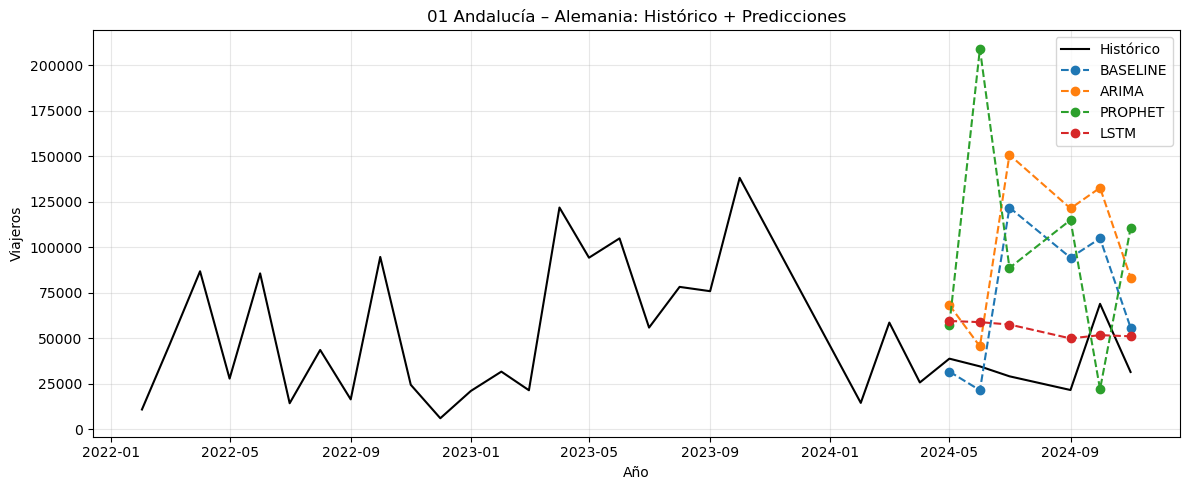

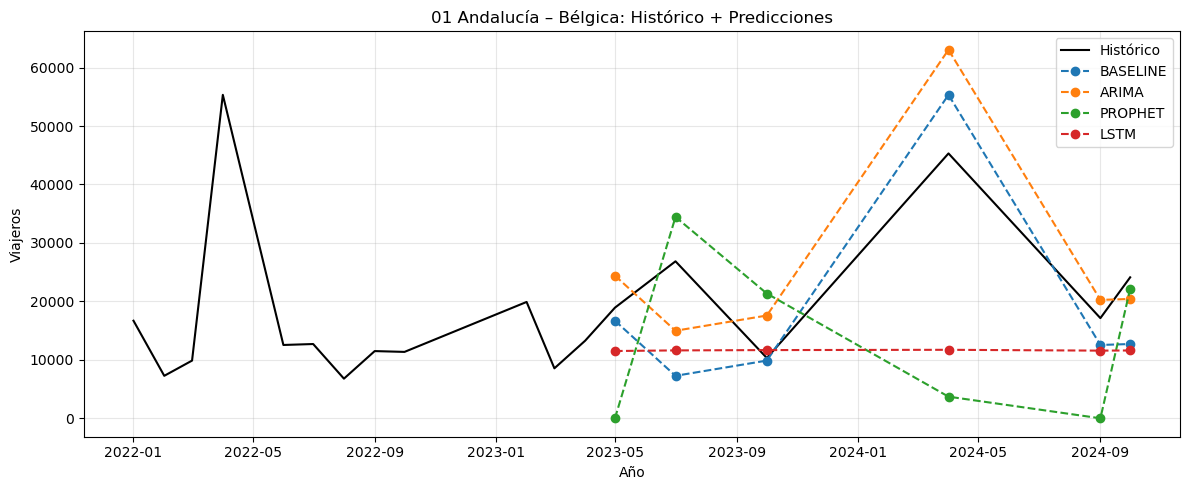

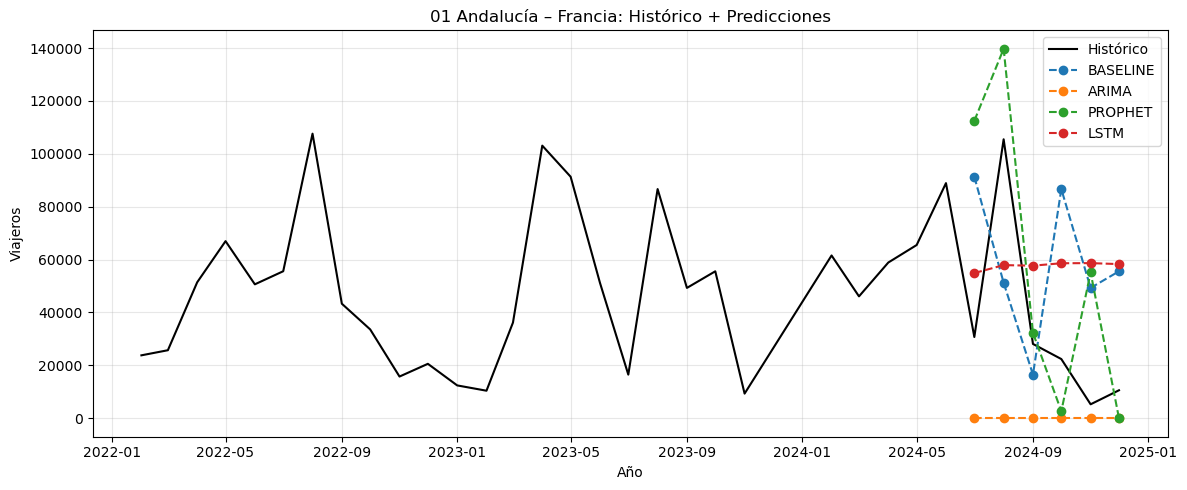

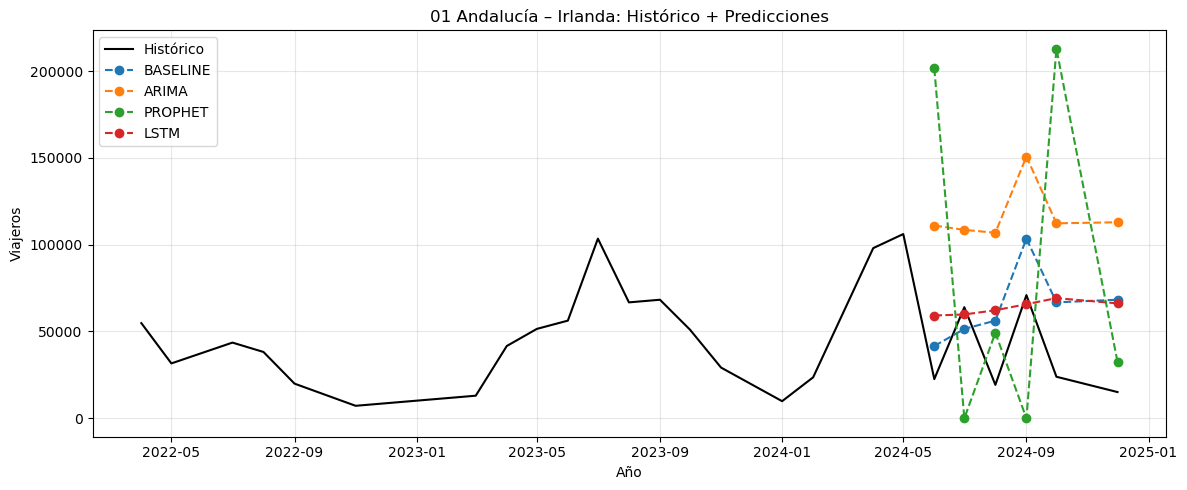

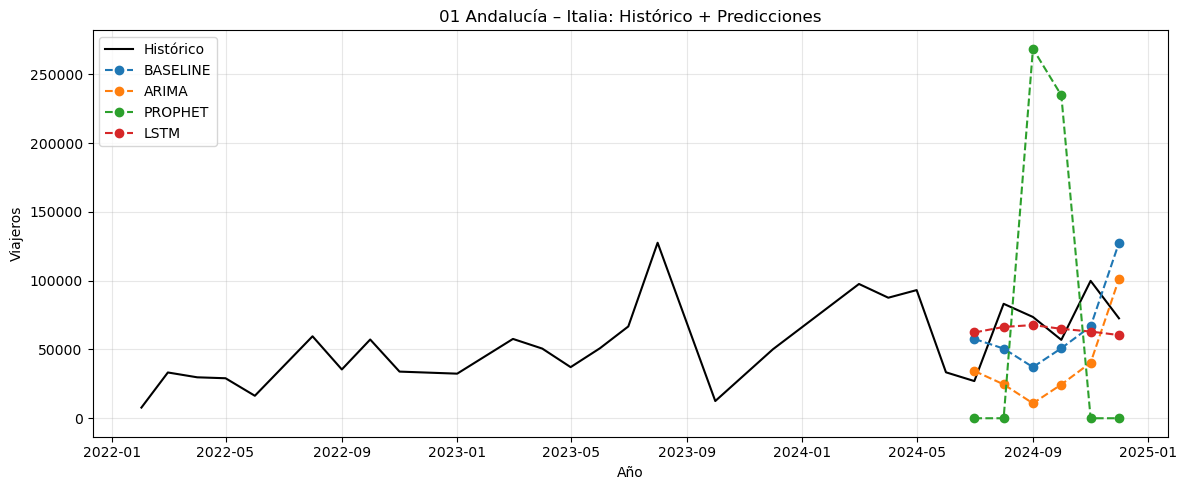

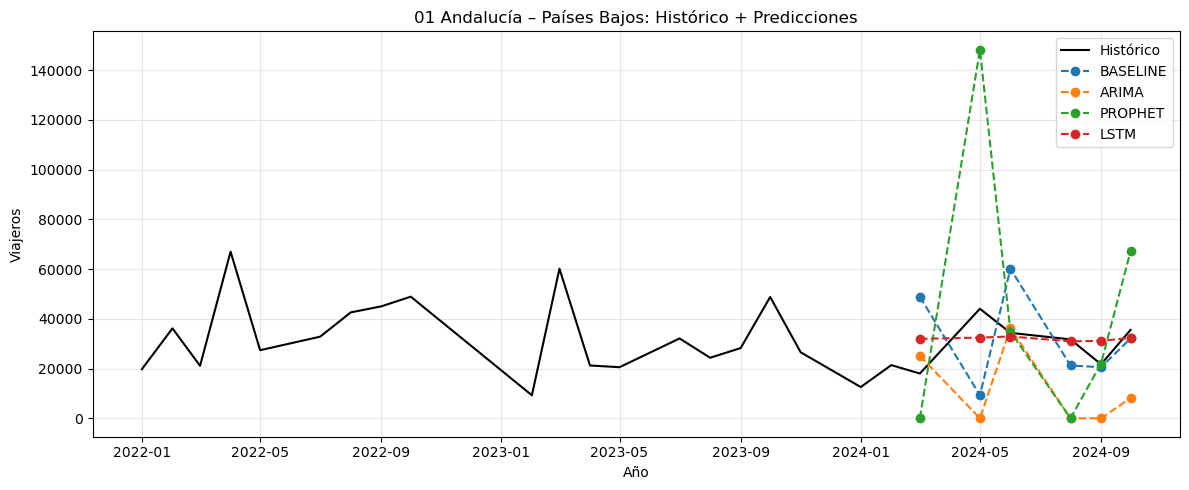

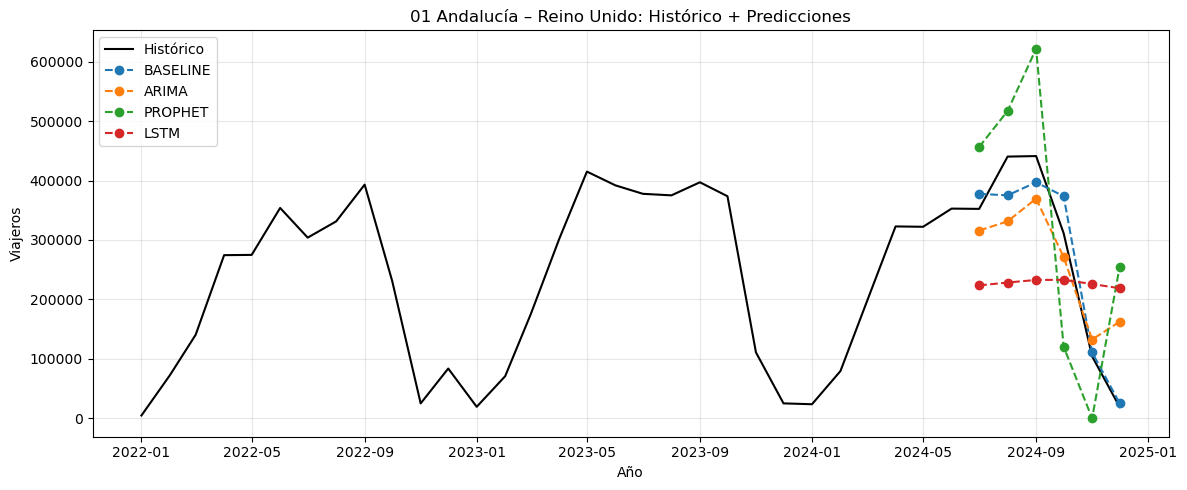

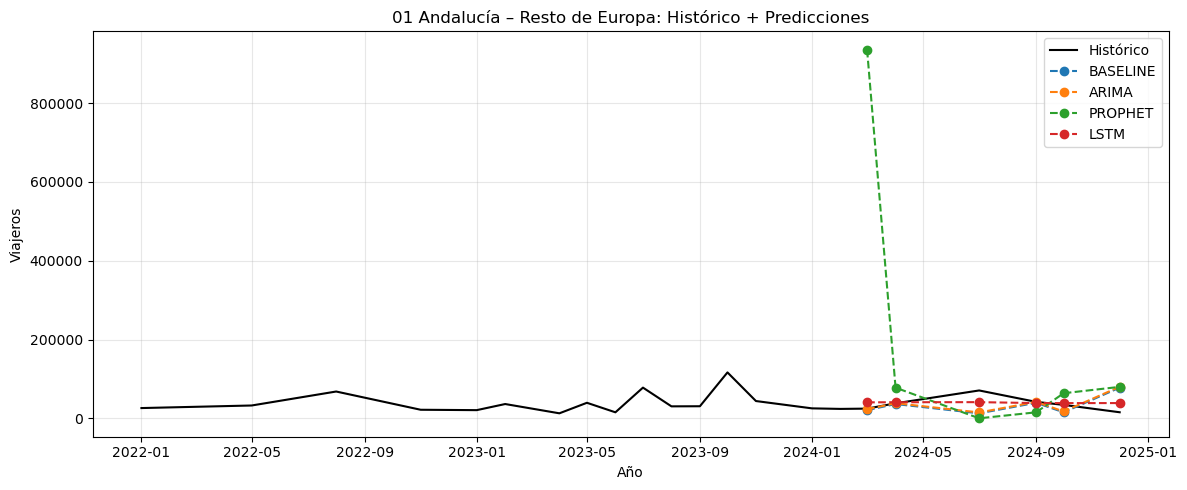

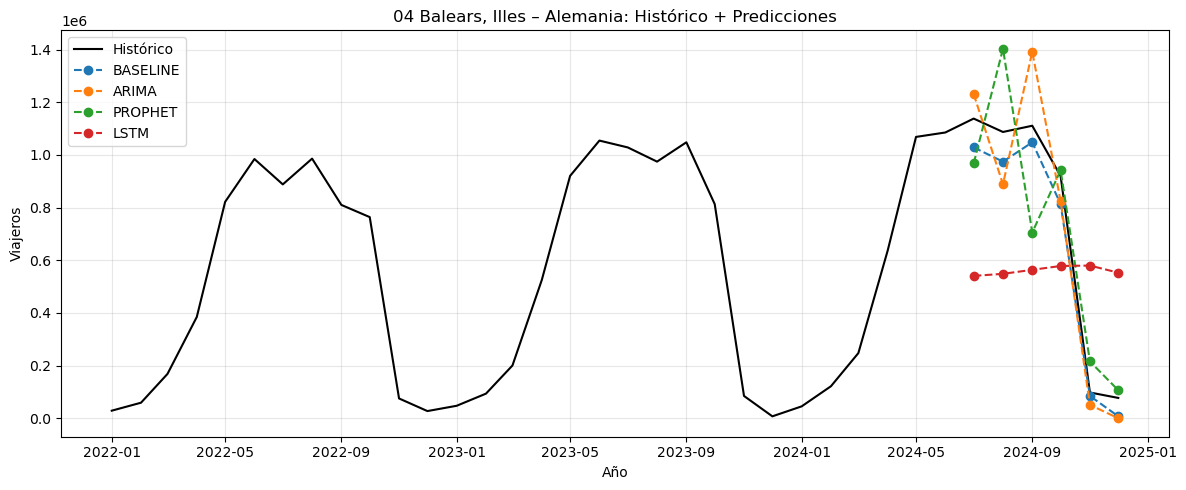

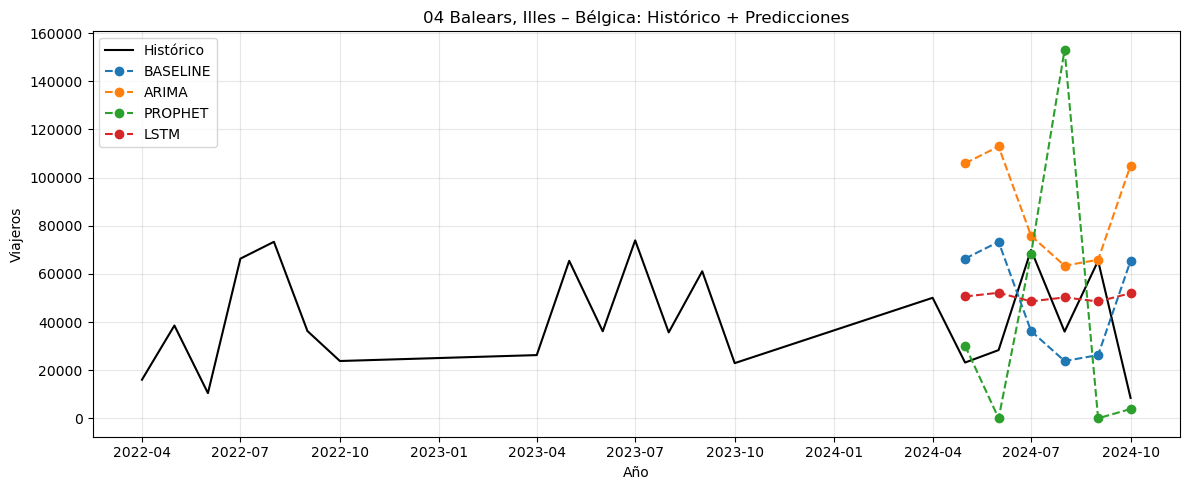

In [11]:
modelos_colores = {
    "observado": "black",
    "baseline": "tab:blue",
    "arima": "tab:orange",
    "prophet": "tab:green",
    "lstm": "tab:red"
}

ejemplos = df_res_original[["CA", "Pais"]].head(10).values.tolist()

for ca, pais in ejemplos:
    df_cp = df_pred_long_original[
        (df_pred_long_original["CA"] == ca) &
        (df_pred_long_original["Pais"] == pais)
    ].sort_values("Periodo")

    df_hist = df_cp[df_cp["Modelo"] == "observado"]

    plt.figure(figsize=(12,5))
    plt.plot(df_hist["Periodo"], df_hist["Valor"], label="Histórico", color="black")

    for modelo in ["baseline", "arima", "prophet", "lstm"]:
        df_m = df_cp[df_cp["Modelo"] == modelo]
        if not df_m.empty:
            plt.plot(df_m["Periodo"], df_m["Valor"],
                     label=modelo.upper(), linestyle="--", marker="o", color=modelos_colores[modelo])

    plt.title(f"{ca} – {pais}: Histórico + Predicciones")
    plt.xlabel("Año")
    plt.ylabel("Viajeros")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 3.3. Resultados preliminares

La representación visual de las predicciones contra el test, muestra resultados dispares para cada modelo.

No obstante, se puede observar lo siguiente:

* **LSTM** muestra una linea muy plana cercana a la media, pero no es indicativa de una buena predicción aunque sus metricas son las mejores.
* **Baseline** demuestra un comportamiento cercano a la realidad en varias de las rutas. Sobre todo en aquellas con una estacionalidad anual más estable.
* **ARIMA** parece tener un buen desempeño en algunas rutas, pero no demasiado.
* **Prophet** no consigue estabilizar las predicciones, debido a la poca cantidad de datos y alta variabilidad en muchas de las rutas.


**CONLUSION PRELIMINAR** 

* Se debe descartar LSTM aun teniendo las mejores metricas, ya que la predicción visual es siempre pobre.
* Se considera necesario realizar modificaciones en ARIMA para ver si se puede mejorar el rendimiento (eliminacion de outliers, transformación logarítmica, creación de medias moviles a 3 meses, e implementacion de auto-arima para evitar parametros fijos).
* Estas modificaciones no son necesarias en Prophet, ya incorpora mecanismos internos frente a outliers y tendencias no lineales. Estando definido como un modelo aditivo, debe operar con los datos a escala original y usar transformmaciones como logarítmos, puede alterar negativamente el comportameinteo del modelo [1].

## 4. Mejoras metodológicas sobre ARIMA

### 4.1. Funciones de transformación

In [12]:
def clip_outliers(serie, factor=3.5):
    q1, q3 = serie.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - factor * iqr
    high = q3 + factor * iqr
    return serie.clip(lower=low, upper=high)

def transform_log1p(serie):
    return np.log1p(serie)

def inverse_log1p(serie_log):
    return np.expm1(serie_log)

def smooth_moving_average(serie, window=3):
    return serie.rolling(window=window, min_periods=1).mean()

def preprocess_serie(serie):
    serie_clip = clip_outliers(serie)
    serie_smooth = smooth_moving_average(serie_clip)
    serie_log = transform_log1p(serie_smooth)
    return serie_smooth, serie_log

### 4.2. Nuevo ARIMA

In [13]:
def fit_predict_autoarima(train_log, steps=H):
    model = pm.auto_arima(train_log, seasonal=True, m=12, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
    return inverse_log1p(model.predict(n_periods=steps))

## 5. Nuevo entrenamiento de modelos (con transformaciones)

Con las nuevas funciones y el modelo auto-ARIMA se lanza otro loop de evaluación de modelos.

*Tras varios intentos, se ha determinado que auto-ARIMA genera algunas predicciones nulas, por lo que se ha implementado que en estos casos, funcione el ARIMA original.*

In [14]:
resultados_mejorados = []
predicciones_largas_mejorado = []

for _, fila in combis_validas.iterrows():
    ca = fila["Comunidad autónoma de destino"]
    pais = fila["País de residencia"]
    serie = df[
        (df["Comunidad autónoma de destino"] == ca) &
        (df["País de residencia"] == pais)
    ]["Total"].sort_index()

    if len(serie) < MIN_MESES:
        continue

    serie_clip, serie_log = preprocess_serie(serie)

    train, test         = make_train_test(serie)
    train_log, test_log = make_train_test(serie_log)

    try:
        pred_base = baseline_seasonal_naive(train, test)
        rmse_b, mae_b, mape_b = eval_metrics(test, pred_base)
    except:
        pred_base = np.full(H, np.nan)
        rmse_b = mae_b = mape_b = np.inf

    try:
        pred_arima = fit_predict_autoarima(train_log, H)
        rmse_a, mae_a, mape_a = eval_metrics(test, pred_arima)
    except:
        try:
            pred_arima = fit_predict_arima(train, H)
            rmse_a, mae_a, mape_a = eval_metrics(test, pred_arima)
        except:
            pred_arima = np.full(H, np.nan)
            rmse_a = mae_a = mape_a = np.inf

    try:
        pred_prophet_test = fit_predict_prophet(train, H)
        rmse_p, mae_p, mape_p = eval_metrics(test, pred_prophet_test)
    except:
        pred_prophet = np.full(H, np.nan)
        rmse_p = mae_p = mape_p = np.inf

    try:
        pred_lstm = fit_predict_lstm(train, H)
        rmse_l, mae_l, mape_l = eval_metrics(test, pred_lstm)
    except:
        pred_lstm = np.full(H, np.nan)
        rmse_l = mae_l = mape_l = np.inf

    resultados_mejorados.append({
        "CA": ca, "Pais": pais,
        "RMSE_baseline": rmse_b,
        "RMSE_arima": rmse_a,
        "RMSE_prophet": rmse_p,
        "RMSE_lstm": rmse_l,
        "MAPE_baseline": mape_b,
        "MAPE_arima": mape_a,
        "MAPE_prophet": mape_p,
        "MAPE_lstm": mape_l
    })

    fechas_test = test.index

    for f, val in zip(serie.index, serie.values):
        predicciones_largas_mejorado.append({
            "CA": ca, "Pais": pais, "Periodo": f,
            "Valor": val, "Tipo": "historico", "Modelo": "observado"
        })

    modelos_preds = {
        "baseline": pred_base,
        "arima": pred_arima,
        "prophet": pred_prophet_test,
        "lstm": pred_lstm
    }

    for modelo, preds in modelos_preds.items():
        for f, p in zip(fechas_test, preds):
            predicciones_largas_mejorado.append({
                "CA": ca, "Pais": pais, "Periodo": f,
                "Valor": max(p, 0), "Tipo": "prediccion", "Modelo": modelo
            })

print("Loop mejorado completado.")

15:21:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:59 - cmdstanpy - INFO - Chain [1] done processing
15:22:03 - cmdstanpy - INFO - Chain [1] start processing
15:22:03 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:16 - cmdstanpy - INFO - Chain [1] start processing
15:22:16 - cmdstanpy - INFO - Chain [1] done processing
15:22:20 - cmdstanpy - INFO - Chain [1] start processing
15:22:20 - cmdstanpy - INFO - Chain [1] done processing
15:22:24 - cmdstanpy - INFO - Chain [1] start processing
15:22:24 - cmdstanpy - INFO - Chain [1] done processing
15:22:27 - cmdstanpy - INFO - Chain [1] start processing
15:22:27 - cmdstanpy - INFO - Chain [1] done processing
15:22:30 - cmdstanpy - INFO - Chain [1] start processing
15:22:31 - cmdstanpy - INFO - Chain [1] done processing
15:22:39 - cmdstanpy - INFO - Chain [1] start processing
15:22:39 - cmdstanpy - INFO - Chain [1]

Loop mejorado completado.


### 5.1. Métricas del nuevo entrenamiento.

Las métricas no muestran un gran cambio respecto a ARIMA como se esperaba.

Aún asi, se espera a su representación visual para corroborar un mejor desempeño.

In [15]:
df_res_mejorado = pd.DataFrame(resultados_mejorados)
display(df_res_mejorado.head())

print("\nConteo de ganadores por RMSE:")
print(df_res_mejorado[["RMSE_baseline", "RMSE_arima", "RMSE_prophet", "RMSE_lstm"]].idxmin(axis=1).value_counts())

print("\nConteo de ganadores por MAPE:")
print(df_res_mejorado[["MAPE_baseline", "MAPE_arima", "MAPE_prophet", "MAPE_lstm"]].idxmin(axis=1).value_counts())


,CA,Pais,RMSE_baseline,RMSE_arima,RMSE_prophet,RMSE_lstm,MAPE_baseline,MAPE_arima,MAPE_prophet,MAPE_lstm
0,01 Andalucía,Alemania,51626.516803,73605.600914,92641.853498,22294.564702,1.402730,2.076143,2.516241,0.691701
1,01 Andalucía,Bélgica,10332.715221,9675.876811,20680.556769,16644.875777,0.308810,0.360430,0.725160,0.453626
2,01 Andalucía,Francia,49735.070871,32805.727712,42543.026580,40021.023431,3.060691,2.160953,2.411265,2.956540
3,01 Andalucía,Irlanda,35634.185424,37794.821458,114089.951946,35361.837708,1.457052,1.426191,3.425249,1.511472
4,01 Andalucía,Italia,35299.811690,59548.843255,124147.935369,21693.881948,0.535825,0.959662,1.628023,0.373561



Conteo de ganadores por RMSE:
RMSE_lstm        20
RMSE_baseline    16
RMSE_arima        4
RMSE_prophet      4
Name: count, dtype: int64

Conteo de ganadores por MAPE:
MAPE_lstm        17
MAPE_baseline    17
MAPE_prophet      6
MAPE_arima        4
Name: count, dtype: int64


### 5.2. Representación visual tras transformaciones.

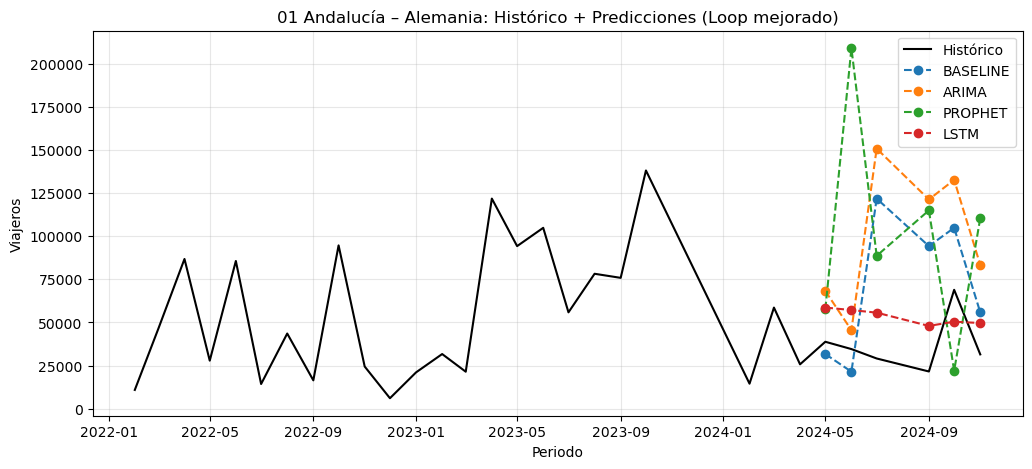

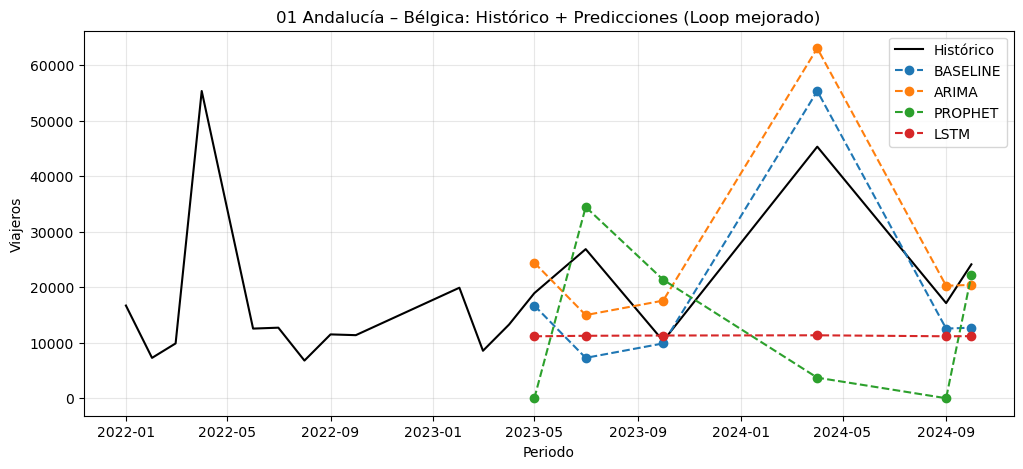

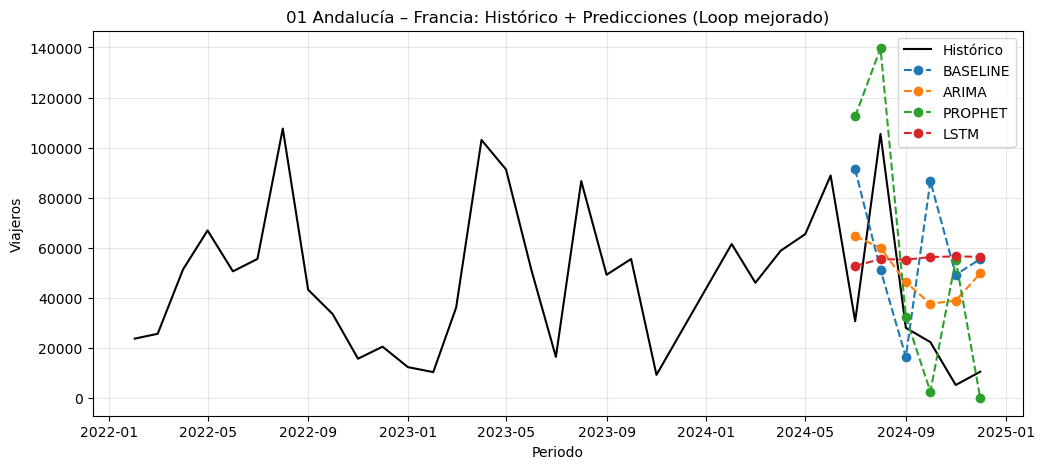

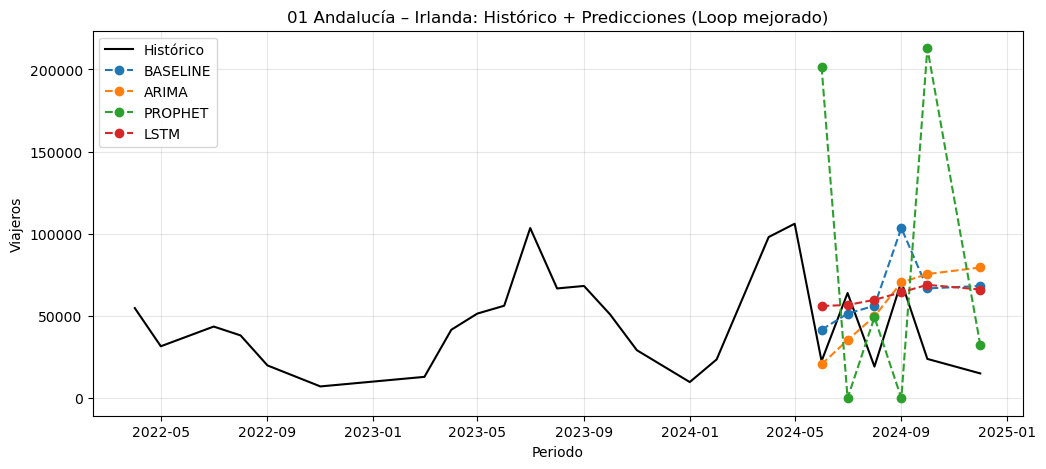

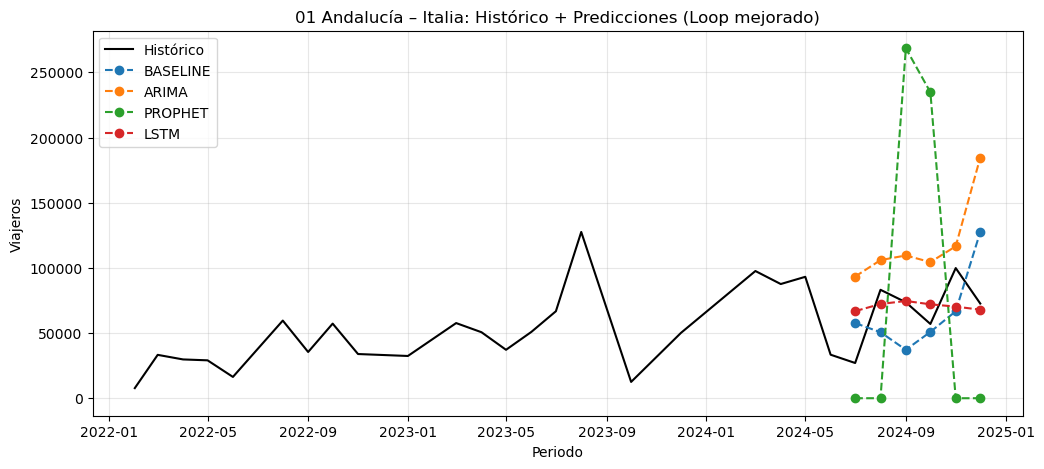

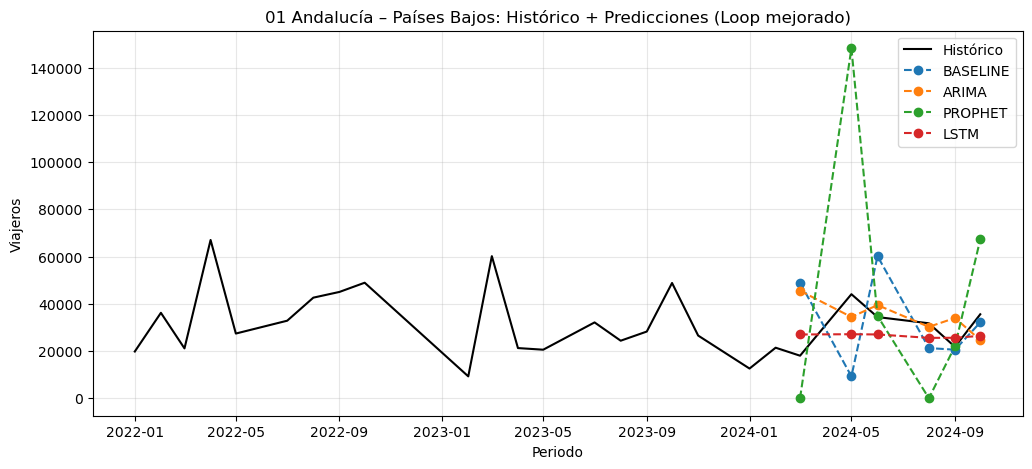

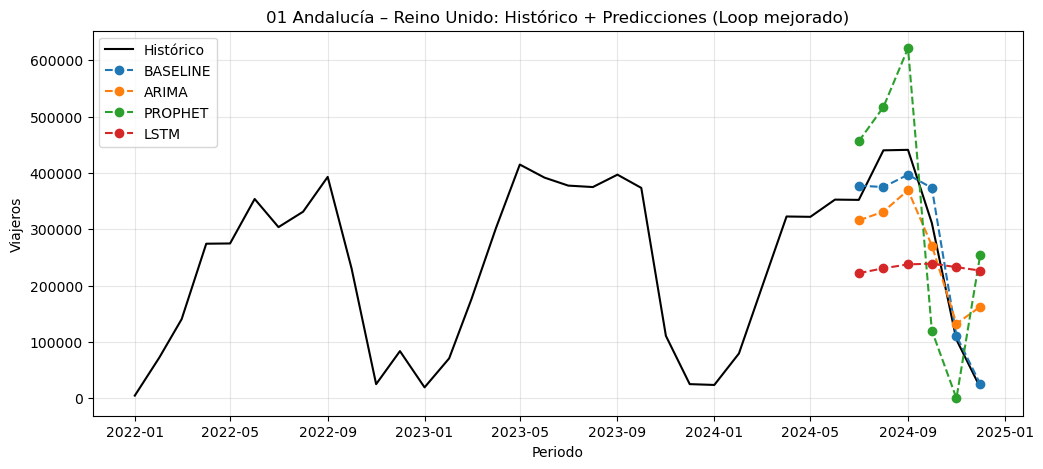

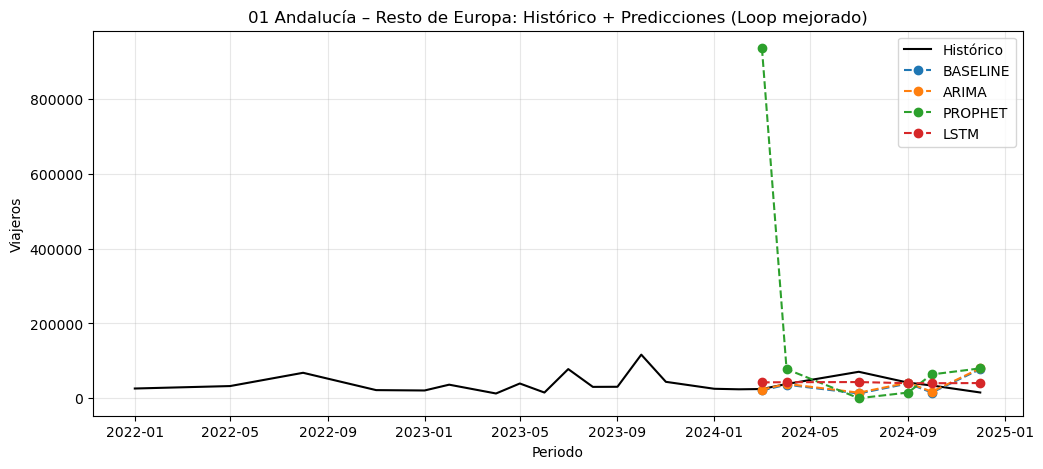

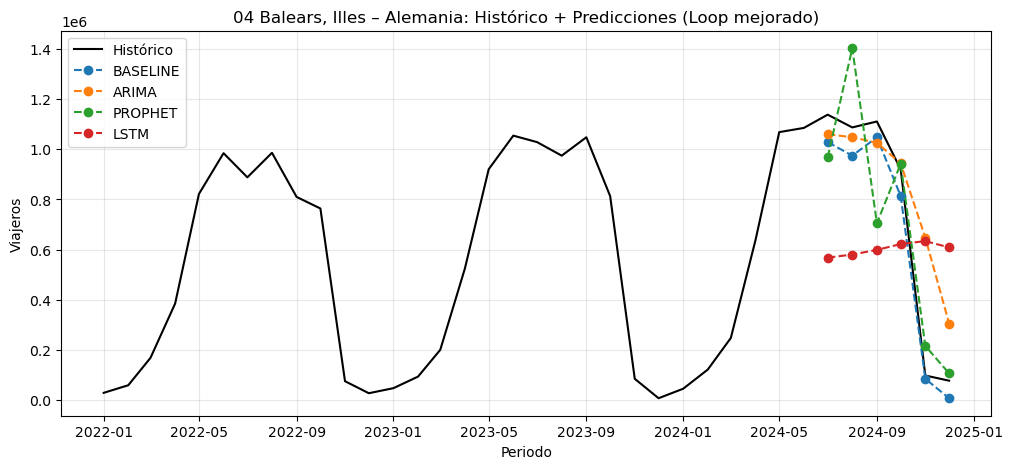

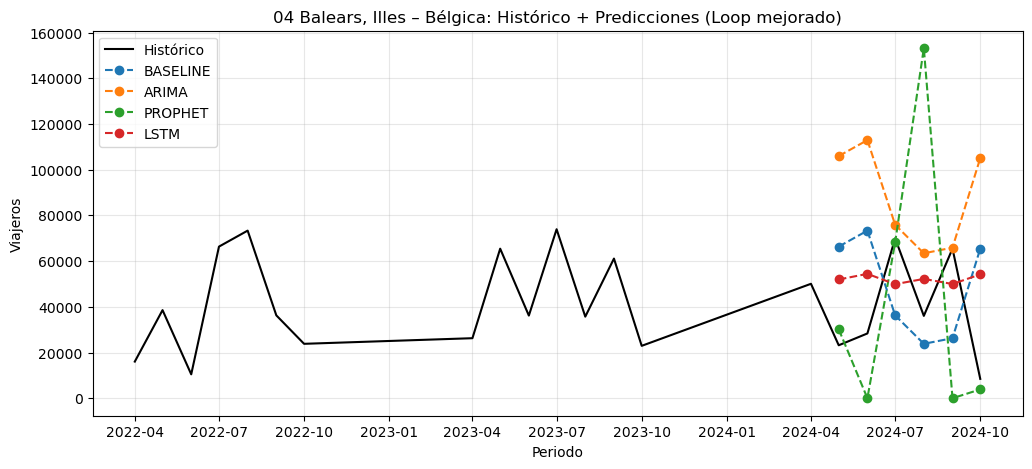

In [16]:
df_pred_long_mejorado = pd.DataFrame(predicciones_largas_mejorado)
ejemplos = df_res_mejorado[["CA", "Pais"]].dropna().head(10).values.tolist()

modelos_colores = {
    "observado": "black",
    "baseline": "tab:blue",
    "arima": "tab:orange",
    "prophet": "tab:green",
    "lstm": "tab:red"
}

for ca, pais in ejemplos:
    df_cp = df_pred_long_mejorado[
        (df_pred_long_mejorado["CA"] == ca) &
        (df_pred_long_mejorado["Pais"] == pais)
    ].sort_values("Periodo")

    df_hist = df_cp[df_cp["Modelo"] == "observado"]

    plt.figure(figsize=(12,5))
    plt.plot(df_hist["Periodo"], df_hist["Valor"], label="Histórico", color="black")

    for modelo in ["baseline", "arima", "prophet", "lstm"]:
        df_m = df_cp[df_cp["Modelo"] == modelo]
        if not df_m.empty:
            plt.plot(df_m["Periodo"], df_m["Valor"],
                     label=modelo.upper(), linestyle="--", marker="o",
                     color=modelos_colores[modelo])

    plt.title(f"{ca} – {pais}: Histórico + Predicciones (Loop mejorado)")
    plt.xlabel("Periodo")
    plt.ylabel("Viajeros")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Las gráficas muestran un comportamiento muy erratico en aquellas rutas con menor estacionalidad y mayor variabilidad, sin mostrar una mejora del modelo ARIMA.

## 6. Comparativa de métricas en los modelos.

In [17]:
# Renombrado de columnas originales y mejoradas
df_res_original = df_res_original.rename(columns={
    "RMSE_baseline": "RMSE_baseline_original",
    "RMSE_arima": "RMSE_arima_original",
    "RMSE_prophet": "RMSE_prophet_original",
    "RMSE_lstm": "RMSE_lstm_original",
    "MAPE_baseline": "MAPE_baseline_original",
    "MAPE_arima": "MAPE_arima_original",
    "MAPE_prophet": "MAPE_prophet_original",
    "MAPE_lstm": "MAPE_lstm_original"
})

df_res_mejorado = df_res_mejorado.rename(columns={
    "RMSE_baseline": "RMSE_baseline_mejorado",
    "RMSE_arima": "RMSE_arima_mejorado",
    "RMSE_prophet": "RMSE_prophet_mejorado",
    "RMSE_lstm": "RMSE_lstm_mejorado",
    "MAPE_baseline": "MAPE_baseline_mejorado",
    "MAPE_arima": "MAPE_arima_mejorado",
    "MAPE_prophet": "MAPE_prophet_mejorado",
    "MAPE_lstm": "MAPE_lstm_mejorado"
})

# Unión
df_comp = df_res_original.merge(df_res_mejorado, on=["CA", "Pais"], how="inner")

# Mejora relativa en RMSE
for modelo in ["baseline", "arima", "prophet", "lstm"]:
    col_before = f"RMSE_{modelo}_original"
    col_after = f"RMSE_{modelo}_mejorado"
    df_comp[f"Mejora_{modelo.upper()}_%"] = 100 * (df_comp[col_before] - df_comp[col_after]) / df_comp[col_before]

# Se muestran las 10 mayores mejoras.
df_comp.sort_values("Mejora_ARIMA_%", ascending=False).head(10)

,CA,Pais,RMSE_baseline_original,RMSE_arima_original,RMSE_prophet_original,RMSE_lstm_original,MAPE_baseline_original,MAPE_arima_original,MAPE_prophet_original,MAPE_lstm_original,...,RMSE_prophet_mejorado,RMSE_lstm_mejorado,MAPE_baseline_mejorado,MAPE_arima_mejorado,MAPE_prophet_mejorado,MAPE_lstm_mejorado,Mejora_BASELINE_%,Mejora_ARIMA_%,Mejora_PROPHET_%,Mejora_LSTM_%
13,"04 Balears, Illes",Reino Unido,568297.957708,9.233769e+07,261733.290802,606058.755020,12.140096,2708.039762,1.549233,4.588738,...,261733.290802,525575.557332,12.140096,2.026409,1.549233,5.265476,0.0,99.435554,0.0,13.279768
3,01 Andalucía,Irlanda,35634.185424,8.292992e+04,114089.951946,36285.397113,1.457052,3.413678,3.425249,1.546528,...,114089.951946,35361.837708,1.457052,1.426191,3.425249,1.511472,0.0,54.425588,0.0,2.545265
5,01 Andalucía,Países Bajos,22188.931828,2.653365e+04,46876.999847,8463.528395,0.623200,0.703499,0.880330,0.271111,...,46876.999847,9649.314651,0.623200,0.468664,0.880330,0.287813,0.0,47.906273,0.0,-14.010543
27,05 Canarias,Suecia,52659.545032,5.299820e+04,50054.700761,39918.575088,2.418709,2.437900,1.833178,4.044159,...,50054.700761,42493.947127,2.418709,1.876227,1.833178,4.433147,0.0,31.680203,0.0,-6.451563
2,01 Andalucía,Francia,49735.070871,4.743669e+04,42543.026580,41155.252718,3.060691,1.000000,2.411265,3.089519,...,42543.026580,40021.023431,3.060691,2.160953,2.411265,2.956540,0.0,30.843139,0.0,2.755977
40,10 Comunitat Valenciana,Resto de Europa,23946.367338,2.476693e+04,33496.438691,17220.093393,0.893523,0.874013,1.873941,0.695519,...,33496.438691,22984.908673,0.893523,1.114899,1.873941,0.575945,0.0,24.857080,0.0,-33.477259
17,05 Canarias,Bélgica,41749.537327,4.986016e+04,106990.097867,23040.537969,1.651969,2.292080,2.926239,0.774763,...,106990.097867,22901.589013,1.651969,1.573925,2.926239,0.805613,0.0,22.052312,0.0,0.603063
22,05 Canarias,Italia,20845.479842,3.808520e+04,43362.463276,20989.198274,0.290990,0.556983,0.537142,0.300385,...,43362.463276,24054.186794,0.290990,0.411358,0.537142,0.334549,0.0,17.332927,0.0,-14.602695
28,09 Cataluña,Alemania,33001.443693,4.006285e+04,60652.594731,51460.708266,0.309490,0.395279,0.443712,0.387067,...,60652.594731,50316.333054,0.309490,0.395279,0.443712,0.394993,0.0,0.000000,0.0,2.223784
29,09 Cataluña,Bélgica,19506.331882,2.234185e+04,51163.039107,16102.280359,1.220489,1.441653,2.582072,0.932928,...,51163.039107,16189.467932,1.220489,1.441653,2.582072,0.946233,0.0,0.000000,0.0,-0.541461


### 6.1. Resultados de las transformaciones de ARIMA

Procedo a visualizar la mejora o empeoramiento del modelo respecto al original.

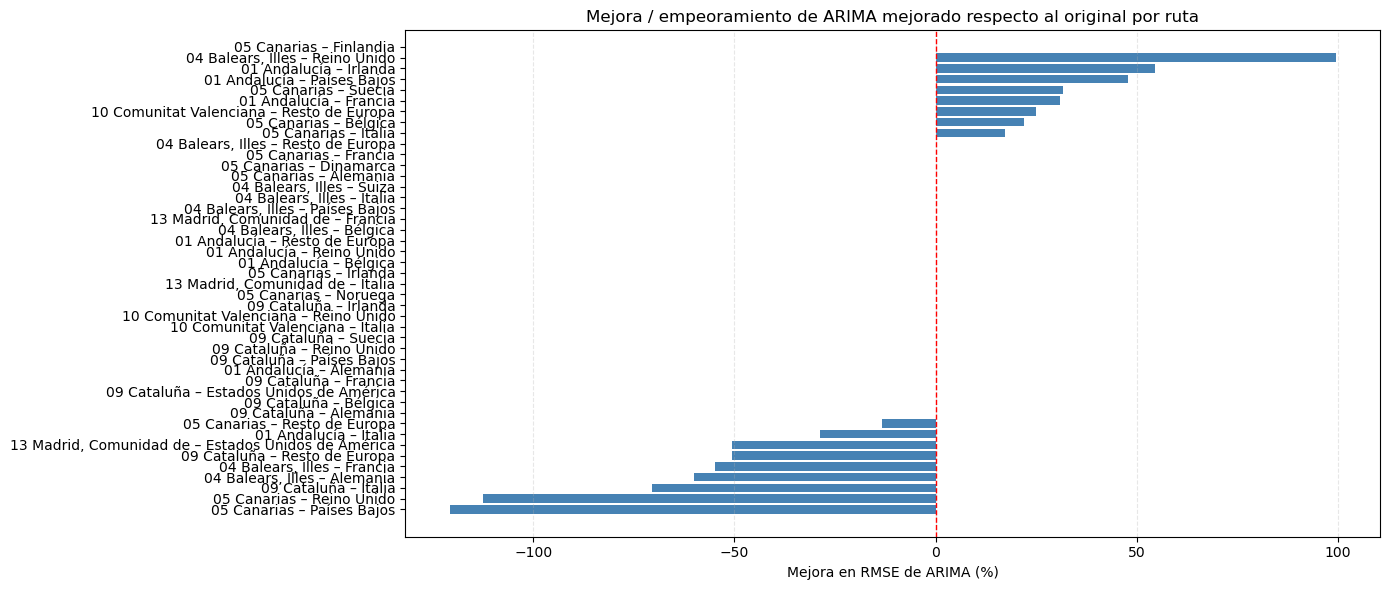

In [18]:
# Ordenamos de peor a mejor (empeoramiento abajo, mejora arriba)
df_arima_plot = df_comp.sort_values("Mejora_ARIMA_%", ascending=True).copy()

plt.figure(figsize=(14, 6))
etiquetas = df_arima_plot["CA"].astype(str) + " – " + df_arima_plot["Pais"].astype(str)

plt.barh(etiquetas, df_arima_plot["Mejora_ARIMA_%"], color="steelblue")
plt.axvline(0, color="red", linestyle="--", linewidth=1)

plt.xlabel("Mejora en RMSE de ARIMA (%)")
plt.title("Mejora / empeoramiento de ARIMA mejorado respecto al original por ruta")
plt.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

Se observa mejora en las rutas que son mas estables y un empeoramiento en el resto que no son tanto. Para muchas, no hay cambio.

A nivel gráfico, se muestra una comparativa entre los antes y los después en cada ruta.

### 6.2. Comparativa visual antes-después

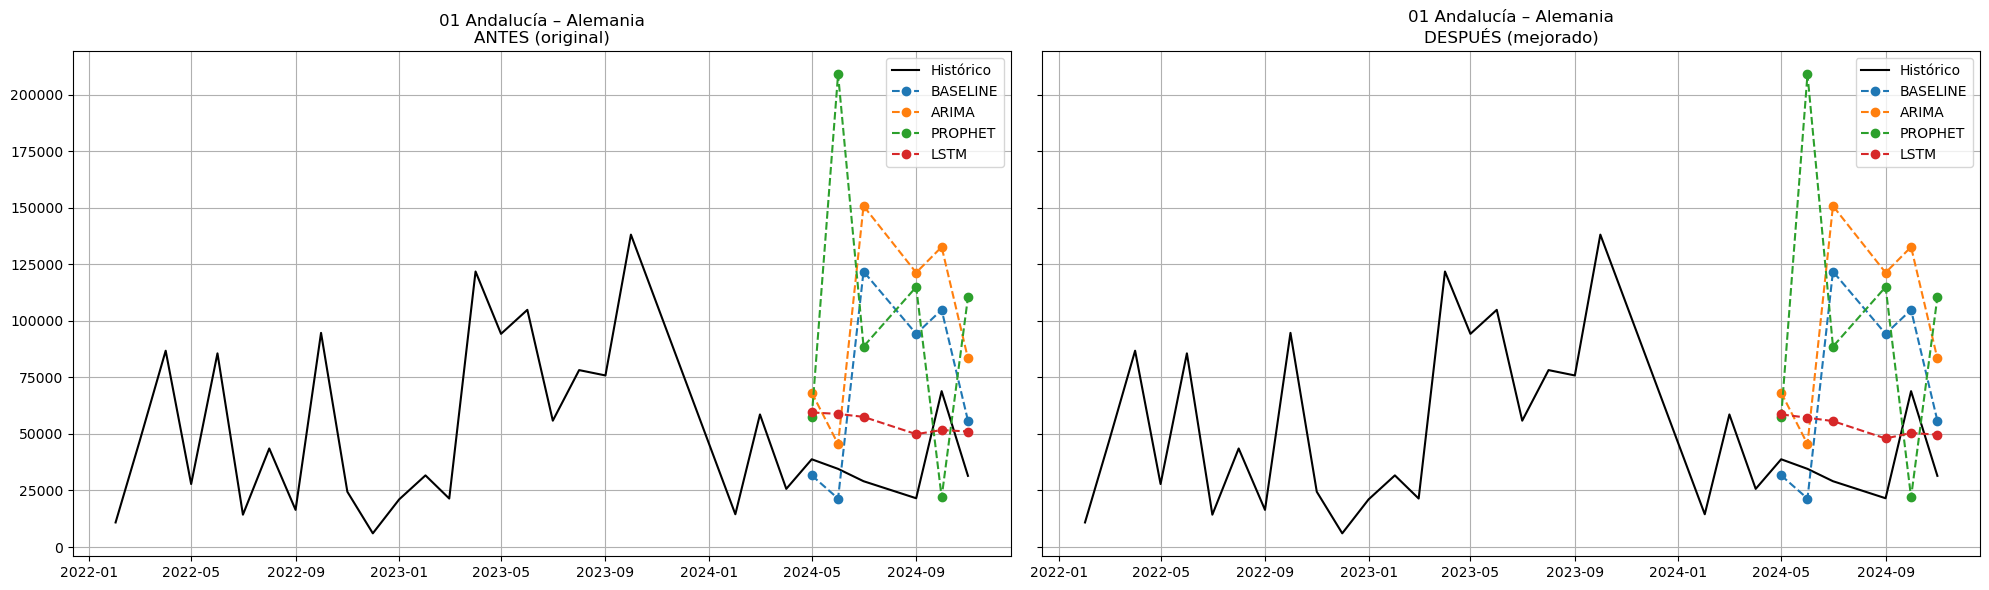

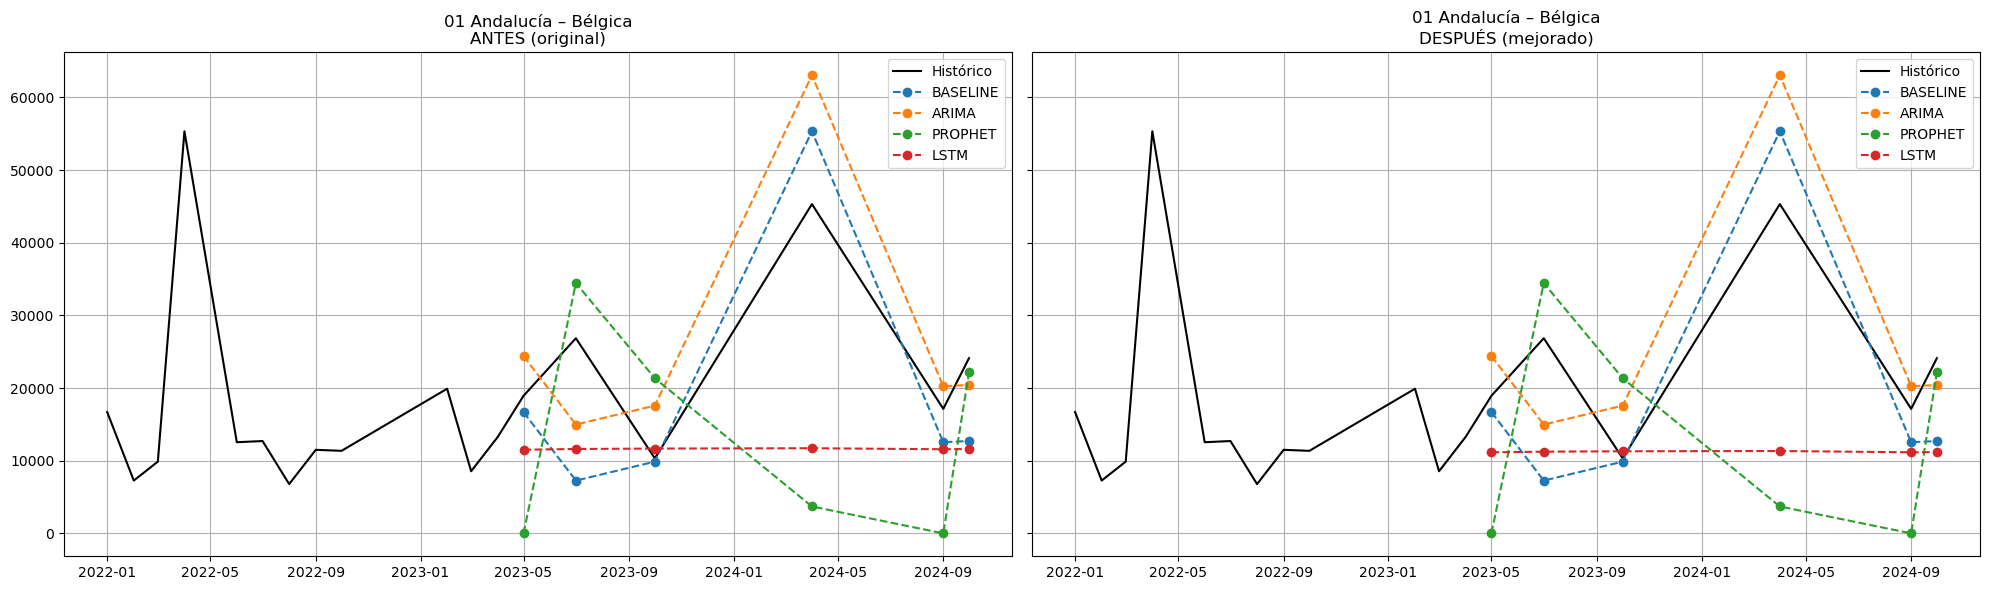

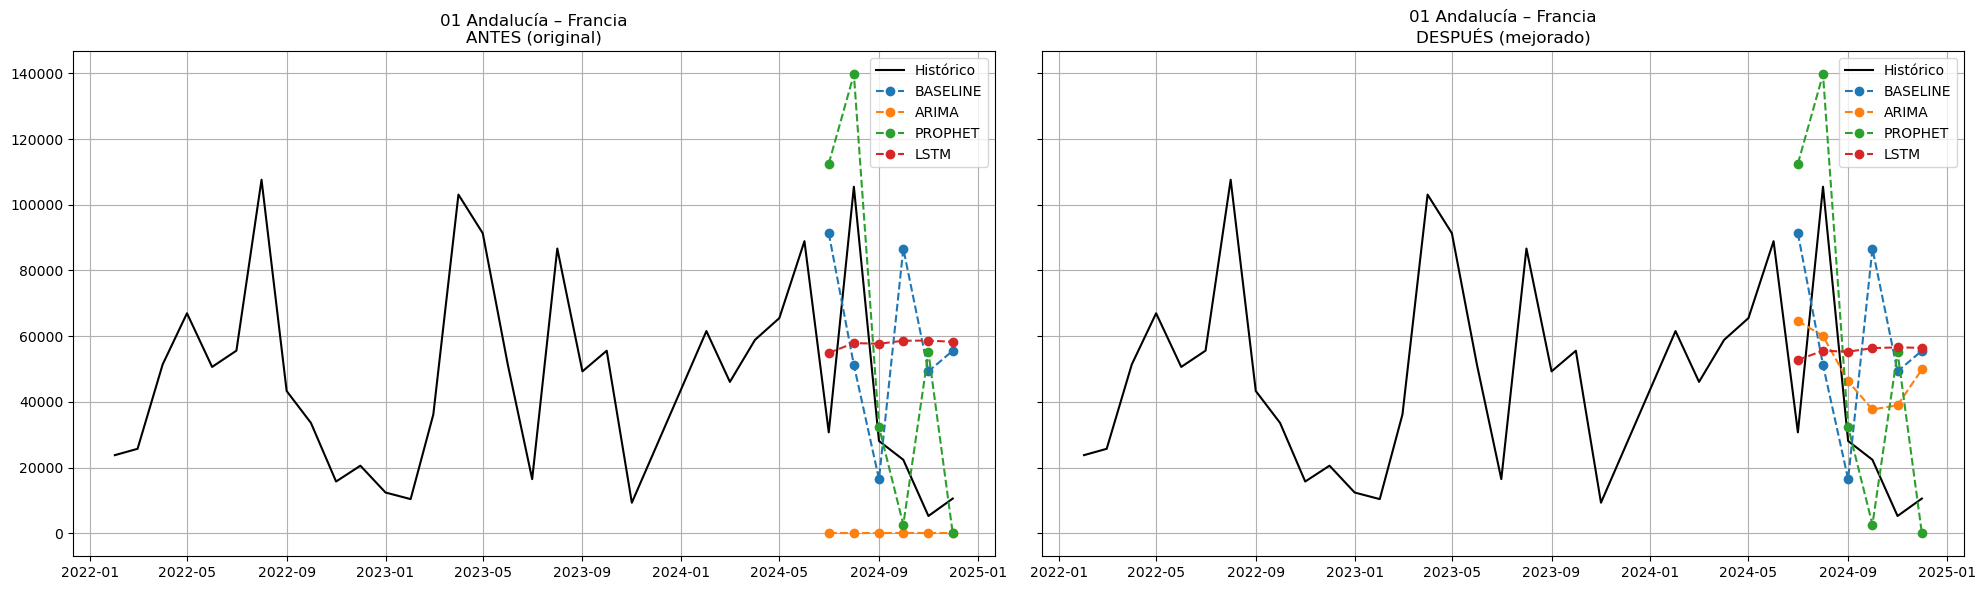

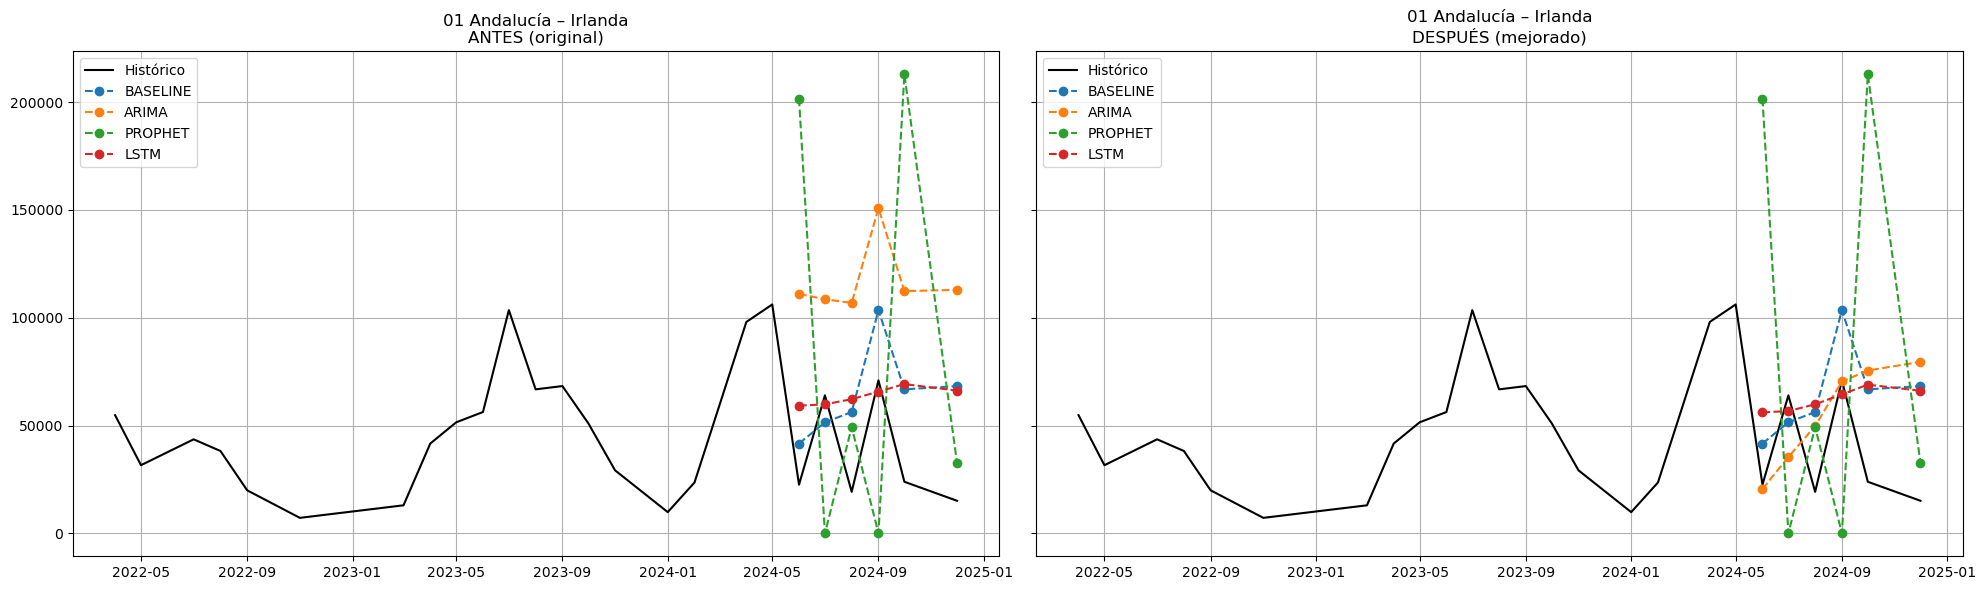

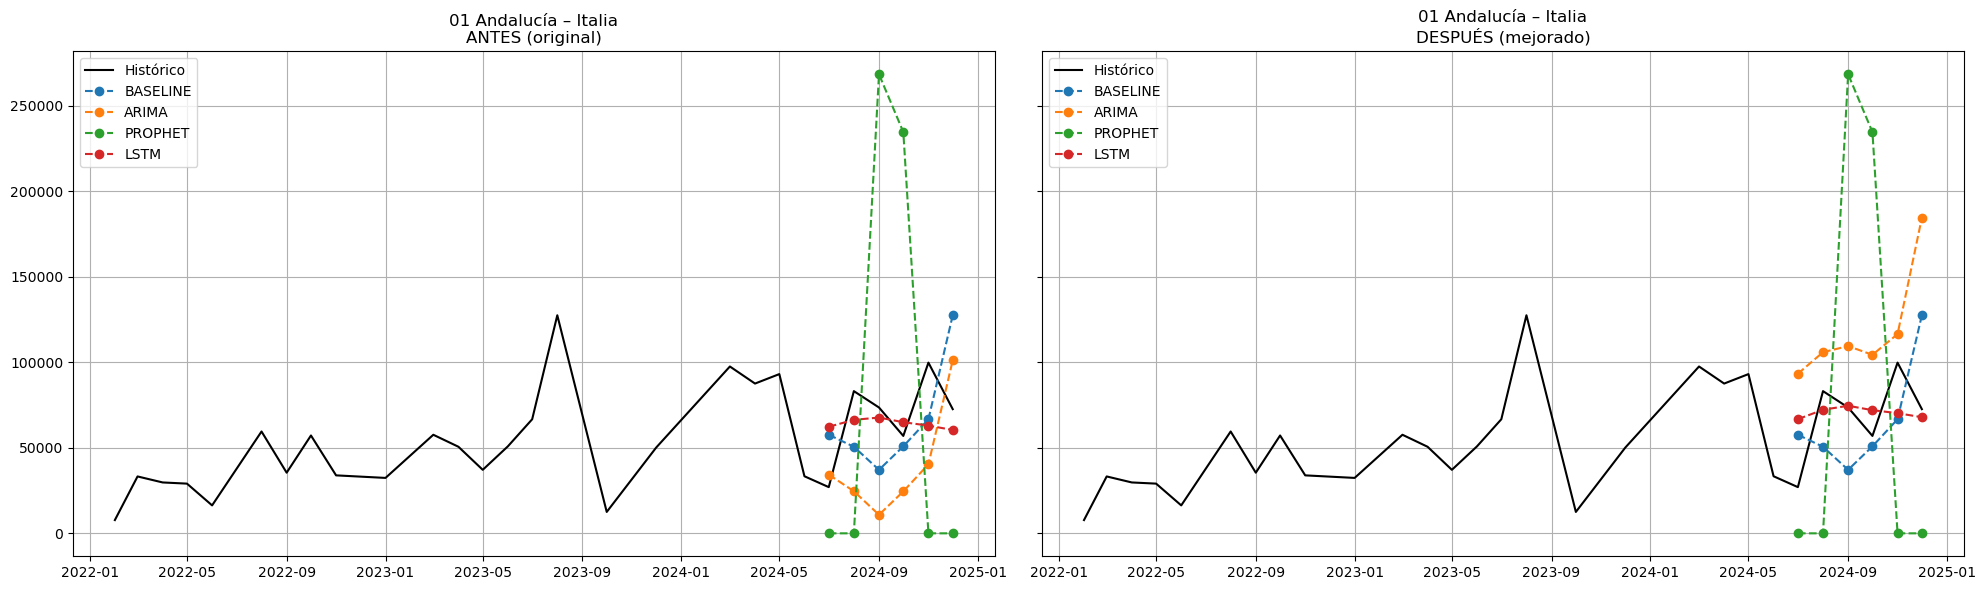

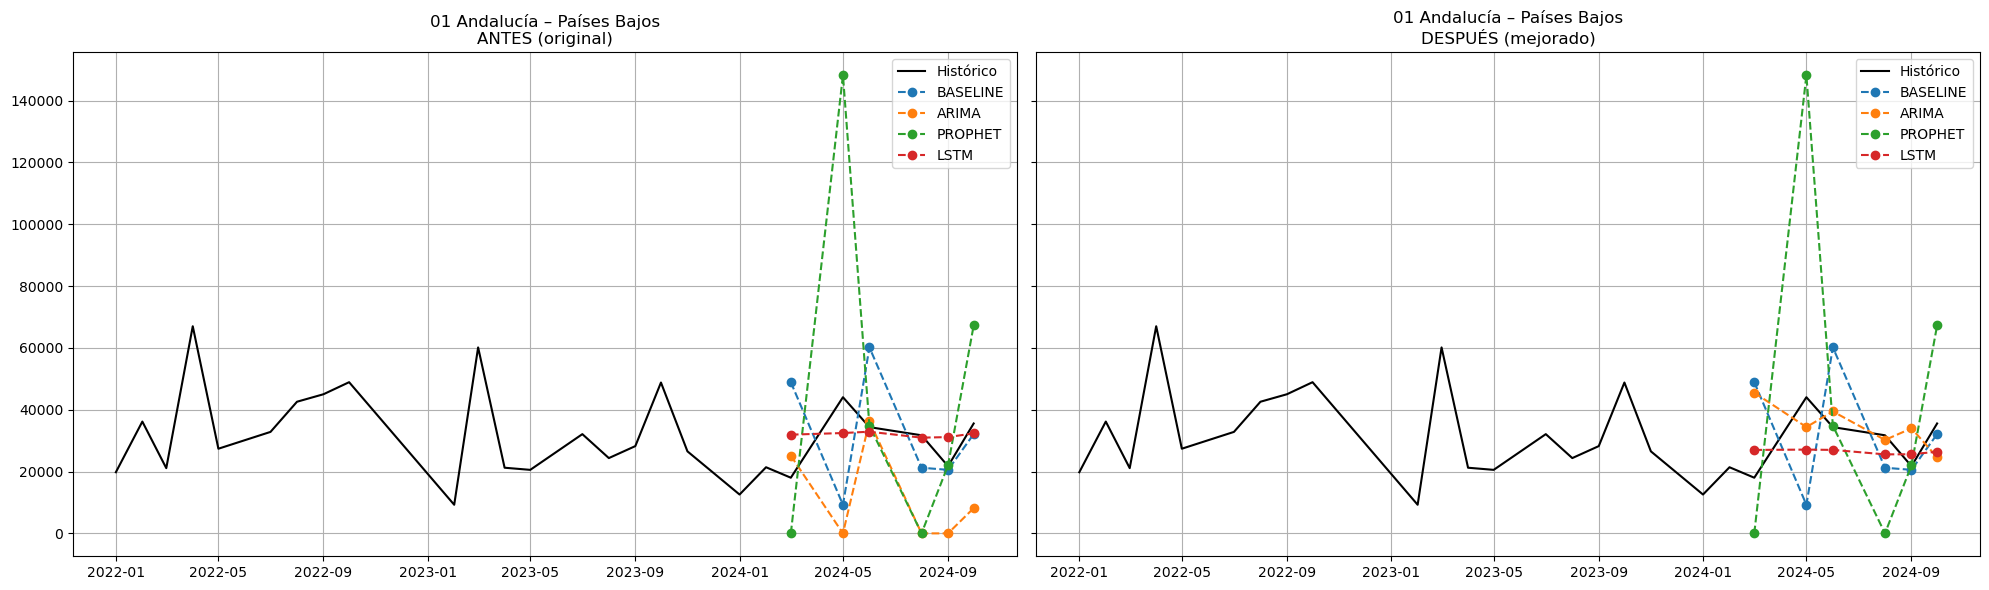

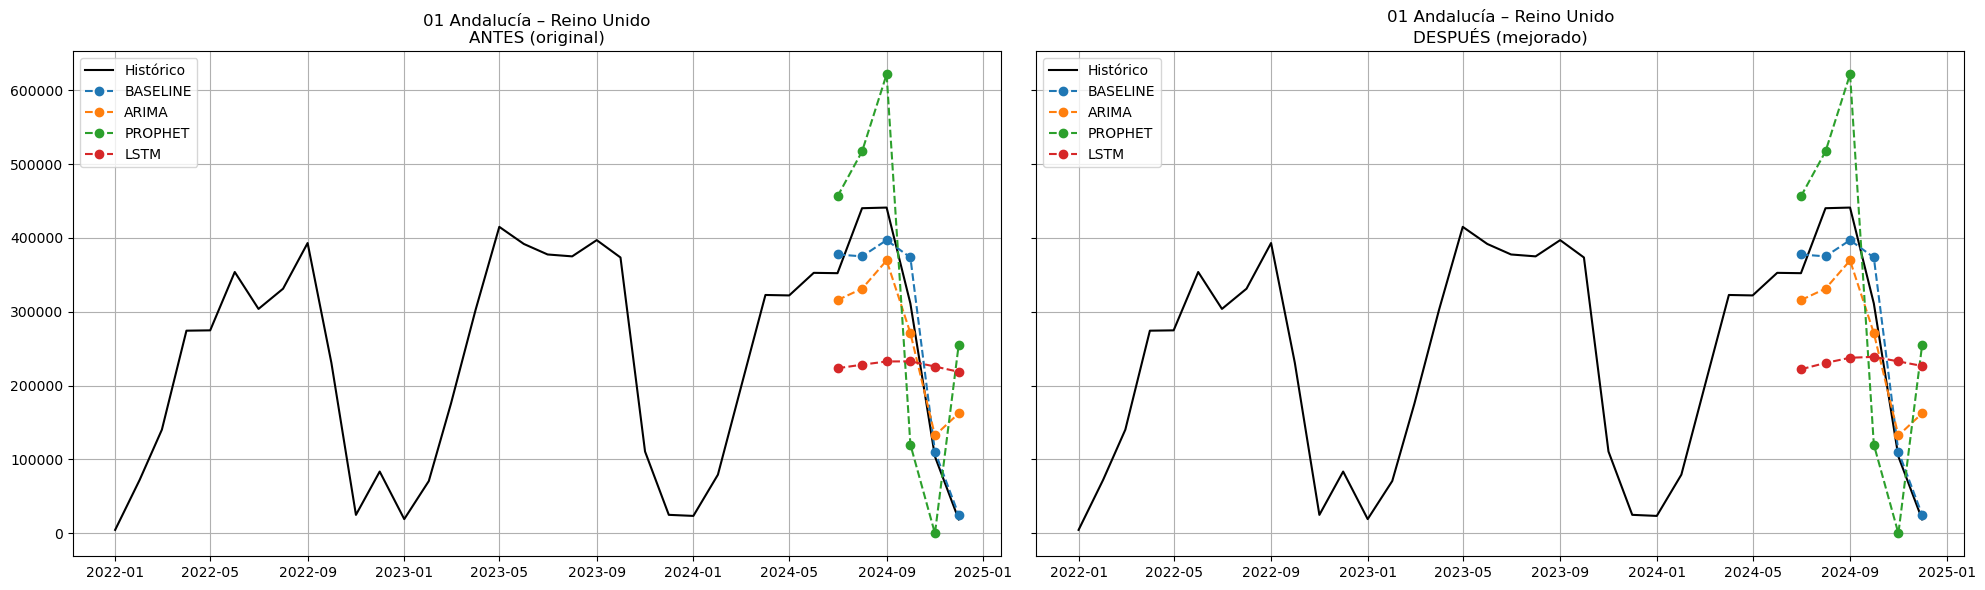

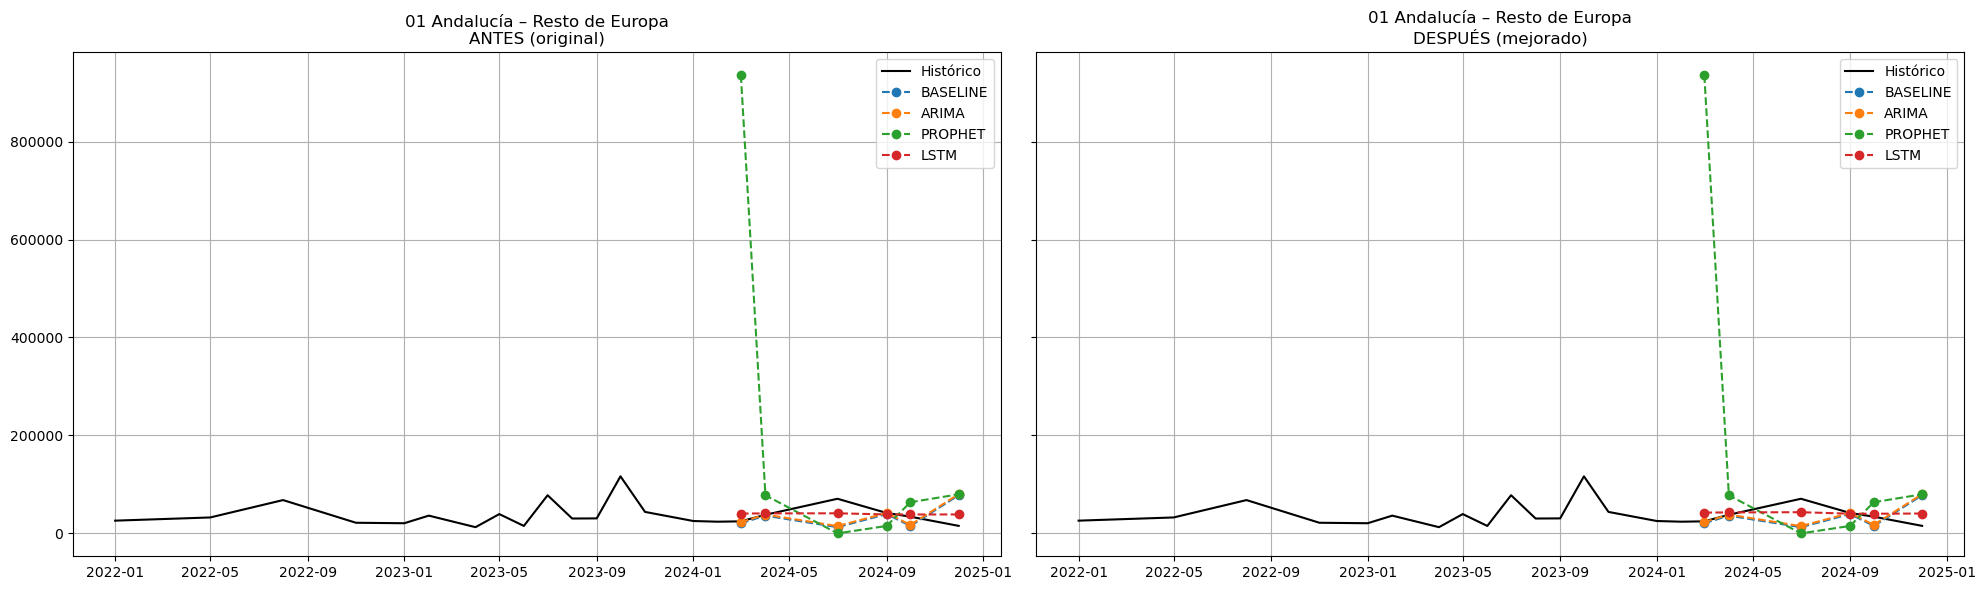

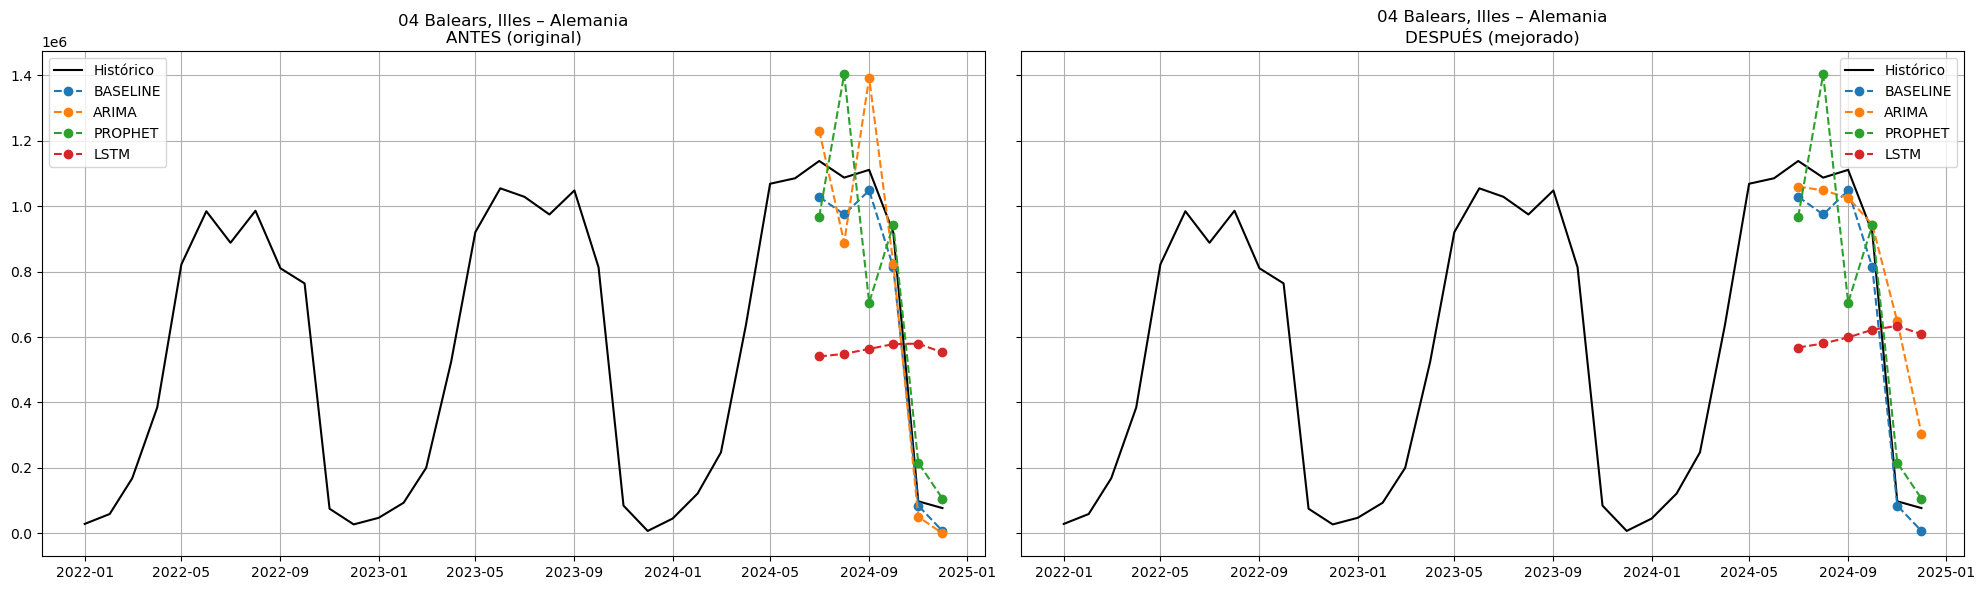

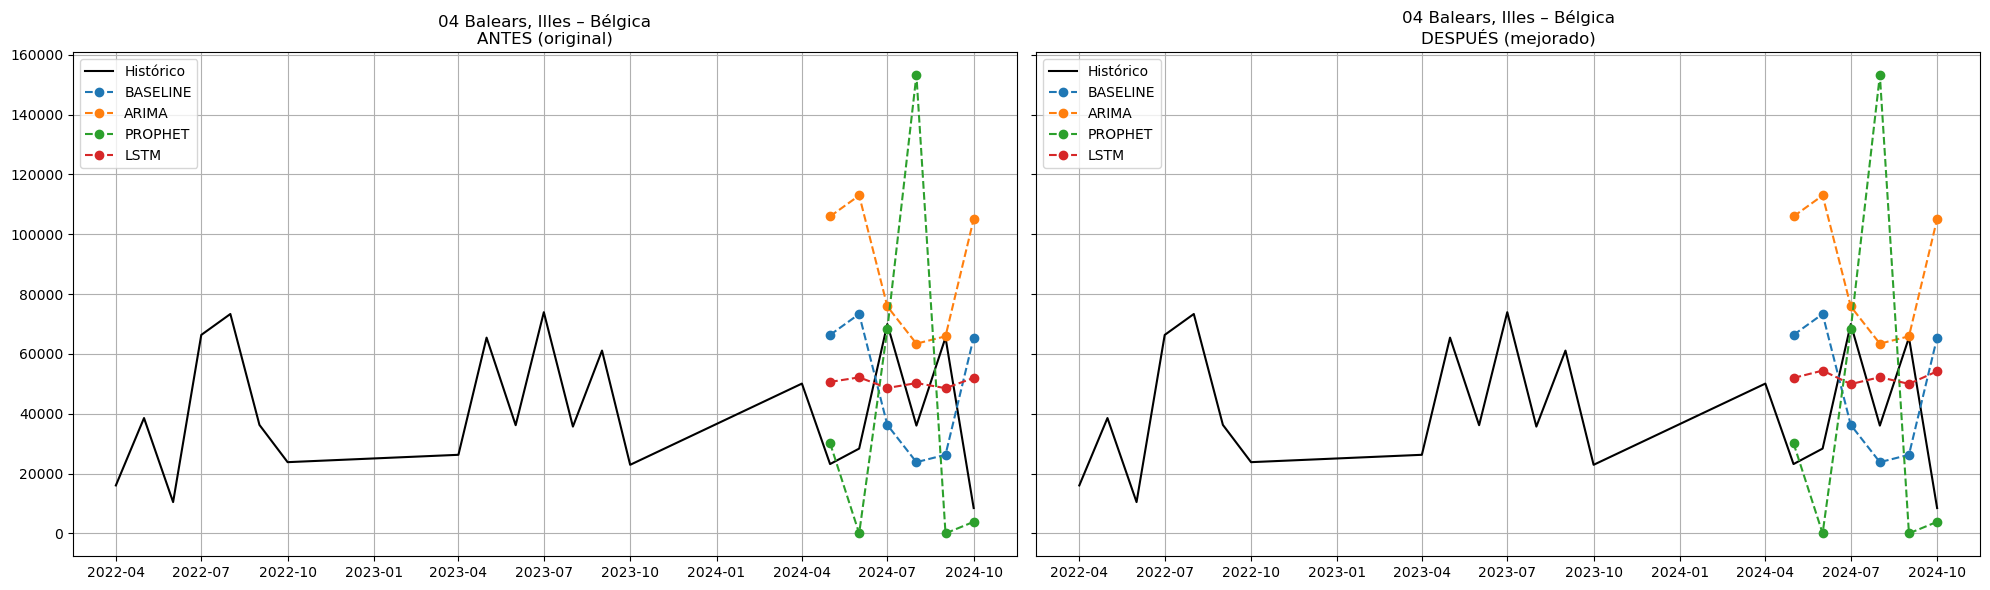

In [19]:
ejemplos = df_comp[["CA", "Pais"]].dropna().head(10).values.tolist()

for ca, pais in ejemplos:

    fig, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)

    # Antes
    df_cp = df_pred_long_original[
        (df_pred_long_original["CA"] == ca) &
        (df_pred_long_original["Pais"] == pais)
    ].sort_values("Periodo")

    axes[0].plot(df_cp[df_cp["Modelo"] == "observado"]["Periodo"],
                 df_cp[df_cp["Modelo"] == "observado"]["Valor"],
                 label="Histórico", color="black")

    for modelo in ["baseline", "arima", "prophet", "lstm"]:
        df_m = df_cp[df_cp["Modelo"] == modelo]
        if not df_m.empty:
            axes[0].plot(df_m["Periodo"], df_m["Valor"], label=modelo.upper(),
                         linestyle="--", marker="o")

    axes[0].set_title(f"{ca} – {pais}\nANTES (original)")
    axes[0].legend()
    axes[0].grid(True)

    # Después
    df_cp2 = df_pred_long_mejorado[
        (df_pred_long_mejorado["CA"] == ca) &
        (df_pred_long_mejorado["Pais"] == pais)
    ].sort_values("Periodo")

    axes[1].plot(df_cp2[df_cp2["Modelo"] == "observado"]["Periodo"],
                 df_cp2[df_cp2["Modelo"] == "observado"]["Valor"],
                 label="Histórico", color="black")

    for modelo in ["baseline", "arima", "prophet", "lstm"]:
        df_m2 = df_cp2[df_cp2["Modelo"] == modelo]
        if not df_m2.empty:
            axes[1].plot(df_m2["Periodo"], df_m2["Valor"], label=modelo.upper(),
                         linestyle="--", marker="o")

    axes[1].set_title(f"{ca} – {pais}\nDESPUÉS (mejorado)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

## 7. Selección modelo ganador.

Con las graficas y las metrícas, se debe decidir un modelo para la predicción. El modelo ganador se selecciona por ruta siguiendo este orden:

* Si ARIMA mejorado reduce el RMSE respecto al baseline (Mejora_ARIMA_% > 0) y su RMSE es menor que el del baseline → se selecciona ARIMA.
* En caso contrario, se selecciona el modelo baseline siempre que su RMSE sea finito y razonable.
* Prophet solo se usa si baseline y ARIMA generan predicciones no válidas (NaN o infinitas).

El RMSE se usa como métrica principal al penalizar más los errores grandes; el MAPE se usa como métrica secundaria para interpretar la magnitud relativa del error.

In [20]:
def seleccionar_modelo(fila):
    rmse_a = fila["RMSE_arima_mejorado"]
    rmse_b = fila["RMSE_baseline_mejorado"]
    rmse_p = fila["RMSE_prophet_mejorado"]
    mejora = fila["Mejora_ARIMA_%"]

    # 1) ARIMA si mejora y es mejor que baseline
    if pd.notna(rmse_a) and pd.notna(rmse_b) and (mejora > 0) and (rmse_a < rmse_b):
        return "arima"
    
    # 2) Si no, baseline
    elif pd.notna(rmse_b) and not np.isinf(rmse_b):
        return "baseline"
    
    # 3) Solo Prophet si baseline/ARIMA no son válidos
    elif pd.notna(rmse_p) and not np.isinf(rmse_p):
        return "prophet"
    
    # 4) Fallback
    else:
        return "sin_modelo"

df_comp["Modelo_seleccionado"] = df_comp.apply(seleccionar_modelo, axis=1)
print(df_comp["Modelo_seleccionado"].value_counts())

Modelo_seleccionado
baseline    38
arima        6
Name: count, dtype: int64


## 8. Generación csv para Power BI

### 8.1. Entrenamiento con modelos ganadores.

Con los modelos ya seleccionados por ruta, se van a hacer las predicciones a futuro. 

Para ello, se genera de nuevo la funcion baseline pero hacía futuro. 

En ARIMA se sigue el mismo patron que el loop mejorado (se usa auto-arima con transformación o ARIMA)

Por ultimo se guarda con formato largo, ya que será el csv que se cargará en Poer BI.

In [21]:
# Baseline estacional para futuro 
def forecast_baseline_seasonal(train, steps, freq=12):
    if len(train) >= freq:
        last_season = train.iloc[-freq:]
        reps = int(np.ceil(steps / freq))
        pred = np.tile(last_season, reps)[:steps]
    else:
        pred = np.repeat(train.iloc[-1], steps)
    return pred

registros_future = []

for _, fila in df_comp.iterrows():
    ca   = fila["CA"]
    pais = fila["Pais"]
    modelo = fila["Modelo_seleccionado"]

    if modelo == "sin_modelo":
        continue  # nada que predecir

    serie = (
        df[
            (df["Comunidad autónoma de destino"] == ca) &
            (df["País de residencia"] == pais)
        ]["Total"]
        .sort_index()
    )

    if len(serie) < MIN_MESES:
        continue

    # Fechas futuras (a partir del último mes disponible)
    last_date = serie.index.max()
    fechas_future = pd.date_range(
        start=last_date + pd.offsets.MonthBegin(1),
        periods=H,
        freq="MS"
    )

    if modelo == "baseline":
        preds = forecast_baseline_seasonal(serie, H, freq=12)

    elif modelo == "arima":
        serie_clip, serie_log = preprocess_serie(serie)
        try:
            preds = fit_predict_autoarima(serie_log, H)
        except Exception:
            preds = fit_predict_arima(serie, H)

    elif modelo == "prophet":
        preds = fit_predict_prophet(serie, H)

    else:
        continue

    for f, p in zip(fechas_future, preds):
        registros_future.append({
            "Comunidad Autonoma de destino": ca,
            "Pais de origen": pais,
            "Fecha": f,
            "Tipo de observacion": "prediccion",
            "Modelo": modelo,
            "Valor": max(float(p), 0.0)  # sin negativos
        })

df_future = pd.DataFrame(registros_future)
print(df_future.head())
print(df_future.shape)

  Comunidad Autonoma de destino Pais de origen      Fecha Tipo de observacion  \
0                  01 Andalucía       Alemania 2024-12-01          prediccion   
1                  01 Andalucía       Alemania 2025-01-01          prediccion   
2                  01 Andalucía       Alemania 2025-02-01          prediccion   
3                  01 Andalucía       Alemania 2025-03-01          prediccion   
4                  01 Andalucía       Alemania 2025-04-01          prediccion   

     Modelo     Valor  
0  baseline   78229.0  
1  baseline   75861.0  
2  baseline  138127.0  
3  baseline   14492.0  
4  baseline   58621.0  
(264, 6)


### 8.2 Generación CSV

In [22]:
# HISTÓRICO
df_hist = (
    df.reset_index()[["Periodo_dt", "Comunidad autónoma de destino", "País de residencia", "Total"]]
      .rename(columns={
          "Periodo_dt": "Fecha",
          "Comunidad autónoma de destino": "Comunidad Autonoma de destino",
          "País de residencia": "Pais de origen",
          "Total": "Valor"
      })
)

df_hist["Tipo de observacion"] = "historico"
df_hist["Modelo"] = "observado"

# HISTÓRICO + FUTURO
df_powerbi = pd.concat([df_hist, df_future], ignore_index=True)

# Orden columnas
df_powerbi = df_powerbi[[
    "Comunidad Autonoma de destino",
    "Pais de origen",
    "Fecha",
    "Tipo de observacion",
    "Modelo",
    "Valor"
]]

# Exportar a CSV
df_powerbi.to_csv("forecasting_powerbi.csv", index=False, encoding="utf-8-sig")
print("Exportado: forecasting_powerbi.csv")

Exportado: forecasting_powerbi.csv


In [23]:
df_powerbi.head()

,Comunidad Autonoma de destino,Pais de origen,Fecha,Tipo de observacion,Modelo,Valor
0,09 Cataluña,Países Bajos,2022-01-01,historico,observado,5742.0
1,05 Canarias,Reino Unido,2022-01-01,historico,observado,316956.0
2,05 Canarias,Suecia,2022-01-01,historico,observado,31438.0
3,09 Cataluña,Alemania,2022-01-01,historico,observado,13974.0
4,05 Canarias,Noruega,2022-01-01,historico,observado,29765.0


## 9. Conclusiones del análisis de modelos de forecasting

Se ha realizado un experimento de comparación de modelos de forecasting con horizonte de 6 meses para cada ruta que cumplia los requisitos (44 en total):

- Se han considerado cuatro enfoques:  
  - **Baseline estacional (seasonal naive)**, que repite el patrón observado 12 meses antes.  
  - **ARIMA “original”**, con una estructura (p, d, q)(P, D, Q)[12] fija.  
  - **ARIMA mejorado**, combinando transformaciones (log1p, suavizado y tratamiento de outliers) con auto-ARIMA y, en caso de fallo, un ARIMA clásico como respaldo.  
  - **Prophet** como modelo aditivo con estacionalidad anual.  
  - **LSTM**, como modelo de deep learning para series temporales.

Los resultados cuantitativos (RMSE y MAPE) y el análisis visual aportan las siguientes conclusiones:

- El **baseline estacional** ofrece un rendimiento competitivo en muchas rutas, capturando bien la estacionalidad y sirviendo como referencia mínima que el resto de modelos deben superar.  
- El **ARIMA original** mejora al baseline en algunas rutas, pero no de siempre.
- El **ARIMA mejorado** consigue reducir el RMSE en un subconjunto de rutas, aunque en otras el comportamiento es similar o incluso ligeramente peor, de modo que no hay un “ganador absoluto”.  
- **Prophet** no aporta mejoras consistentes frente a baseline y ARIMA al ser series relativamente cortas con fuerte estacionalidad anual.  
- **LSTM**, a pesar de obtener buenas métricas en casi todos los casos, tiende a producir predicciones excesivamente planas, cercanas a una media, lo que reduce su interpretabilidad y no aporta valor frente a alternativas más simples.

Así pues, el modelo que se utiliza finalmente **ruta a ruta** para el producto en Power BI se selecciona con el siguiente criterio:

1. Si el **ARIMA mejorado** reduce el RMSE respecto al baseline (Mejora_ARIMA_% > 0) y su RMSE es menor que el del baseline, se selecciona **ARIMA** como modelo ganador para esa ruta.  
2. En caso contrario, se selecciona el **baseline estacional**, siempre que sus métricas sean válidas (sin valores NaN o infinitos).  
3. **Prophet** queda como opción de respaldo únicamente en aquellos casos donde baseline y ARIMA no proporcionan predicciones válidas.  
4. **LSTM** se descarta como modelo candidatos a producción por la falta de coherencia visual de sus predicciones, a pesar de las métricas numéricas.

El CSV final exportado para Power BI incluye, para cada combinación de comunidad autónoma y país, el histórico completo y las predicciones a 6 meses con el **modelo ganador**, permitiendo comparar visualmente el pasado reciente y el escenario previsto a corto plazo.

# BIBLIOGRAFIA

* Amat Rodrigo, J., Carazo, F., & Escobar Ortiz, J. (2024). Deep learning para la predicción de series temporales: Redes neuronales recurrentes (RNN), gated recurrent unit (GRU) y long short-term memory (LSTM). Cienciadedatos.net. https://cienciadedatos.net/documentos/py54-forecasting-con-deep-learning

* Davis, J. (2024). How to build LSTM models for time series prediction in Python. Statology. https://www.statology.org/how-to-build-lstm-models-for-time-series-prediction-in-python/

* Hyndman, R. J., & Athanasopoulos, G. (2021). Forecasting: Principles and practice (3rd ed.). OTexts.

* Petropoulos, F., Makridakis, S., Spiliotis, E., Assimakopoulos, V., & Nikolopoulos, K. (2022). The M5 competition: Background, organization, and implementation. International Journal of Forecasting, 38(4), 1325–1336. https://doi.org/10.1016/j.ijforecast.2021.10.001

* Taylor, S. J., & Letham, B. (2018). Prophet: Forecasting at scale – Diagnostics. Facebook. https://facebook.github.io/prophet/docs/diagnostics.html


